In [620]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os 
import matplotlib.ticker as ticker
from main import evaluate
from opponent import make_opponent
from gymnasium import spaces
from TD3_agent import TD3_Agent
import hockey.hockey_env as hockey_env


# Win rates after training
Find the most promising candidate to continue training upon

In [394]:
# load all available final agents
JOB_IDs = {"Opponent: strong, Iter=1, Gaussian/Orn": "1985807", 
           "Opponent: strong, Iter=8/4, Gauss/Orn": "1985808",
           "Opponent: strong, Iter=1, Pink": "1986229",
           "Opponent: strong, Iter=1, Pink, Prioritized ER": "1986341",
           "Opponent: strong, Iter=1, Gaussian, Prioritized ER": "1986633",
           "Opponent: pretrained self, Iter=1, Pink, Prioritized ER": "1986931",
           "Opponent: current self, Iter=1, Pink": "1986278",
           "Opponent: current self, Iter=1, Ornstein": "1986284",
           "Opponent: weak, Iter=1, Ornstein-Uhlenbeck, normal buffer": "1986415",
           "Opponent: weak, Iter=1, Ornstein-Uhlenbeck": "1986036", # slightly lower win rate in eval
           "Opponent: weak, Iter=1, Gaussian": "1985908", # can also have 99.5% seldomly
           "Opponent: weak, Iter=1, Pink": "1986002", # slightly lower win rate (99.5%)
           "Opponent: weak, Iter=1, Ornstein, Prioritized ER": "1986413",
           } 
paths_map = {name: f"./{job_id}/saved/td3_final.pt" for name, job_id in JOB_IDs.items()}


In [260]:
# ── EVALUATION HELPER ─────────────────────────────
def evaluate_matchup(agent_path, opponent_path, n_games=200):
    """
    Play agent (from agent_path) vs opponent (from opponent_path).
    Returns (wins, losses, ties) from agent's perspective.
    If opponent_path is 'weak' or 'strong', uses BasicOpponent.
    """
    env = hockey_env.HockeyEnv()
    obs_dim = env.observation_space.shape[0]
    full_action_space = env.action_space
    n_per_player = full_action_space.shape[0] // 2
    action_space = spaces.Box(
        low=full_action_space.low[:n_per_player],
        high=full_action_space.high[:n_per_player],
        dtype=full_action_space.dtype
    )

    # load agent
    agent = TD3_Agent(
        obs_dim=obs_dim, act_dim=n_per_player,
        observation_space=env.observation_space,
        action_space=action_space, device='cpu'
    )
    agent.load(agent_path)

    # load opponent
    if opponent_path == 'weak':
        opponent = hockey_env.BasicOpponent(weak=True)
        opp_type = 'weak'
    elif opponent_path == 'strong':
        opponent = hockey_env.BasicOpponent(weak=False)
        opp_type = 'strong'
    else:
        opponent = TD3_Agent(
            obs_dim=obs_dim, act_dim=n_per_player,
            observation_space=env.observation_space,
            action_space=action_space, device='cpu'
        )
        opponent.load(opponent_path)
        opp_type = 'pretrained_self'

    wins, losses, ties = 0, 0, 0
    for _ in range(n_games):
        s1, _ = env.reset()
        s2 = env.obs_agent_two()
        ended = False
        while not ended:
            a1 = agent.select_action(s1, explore=False)
            if isinstance(opponent, hockey_env.BasicOpponent):
                a2 = opponent.act(s2)
            else:
                a2 = opponent.select_action(s2, explore=False)
            s1, _, terminated, truncated, info = env.step(np.hstack([a1, a2]))
            s2 = env.obs_agent_two()
            ended = terminated or truncated

        w = info.get('winner', 0)
        if w == 1:    wins += 1
        elif w == -1: losses += 1
        else:         ties += 1

    env.close()
    return wins, losses, ties

In [395]:
# ── RUN ALL MATCHUPS ──────────────────────────────
agent_names = list(paths_map.keys())
N_GAMES = 200
# include weak and strong as "opponents" for the columns
all_opponents = ['weak', 'strong'] + agent_names


In [ ]:

# results[row_agent][col_opponent] = (wins, losses, ties)
results = {}

for name1 in agent_names:
    results[name1] = {}
    path1 = paths_map[name1]
    
    # vs weak
    print(f'{name1} vs weak ...', end=' ')
    w, l, t = evaluate_matchup(path1, 'weak', N_GAMES)
    results[name1]['weak'] = (w, l, t)
    print(f'W={w} L={l} T={t}')
    
    # vs strong
    print(f'{name1} vs strong ...', end=' ')
    w, l, t = evaluate_matchup(path1, 'strong', N_GAMES)
    results[name1]['strong'] = (w, l, t)
    print(f'W={w} L={l} T={t}')
    
    # vs other agents
    for name2 in agent_names:
        if name1 == name2:
            results[name1][name2] = None  # skip self
            continue
        print(f'{name1} vs {name2} ...', end=' ')
        path2 = paths_map[name2]
        w, l, t = evaluate_matchup(path1, path2, N_GAMES)
        results[name1][name2] = (w, l, t)
        print(f'W={w} L={l} T={t}')

print('\nAll matchups complete.')

In [396]:
# evaluate against "strong, Ornstein, PER": "1986620"
additional_jobs = {
    "strong, Ornstein, PER": "1986620",
    "pool, Gaussian, PER": "1987284",
    }
paths_map_additional_jobs = {name: f"./{job_id}/saved/td3_final.pt" for name, job_id in additional_jobs.items()}

additional_names = list(paths_map_additional_jobs.keys())

In [423]:
paths_map

{'Opponent: strong, Iter=1, Gaussian/Orn': './1985807/saved/td3_final.pt',
 'Opponent: strong, Iter=8/4, Gauss/Orn': './1985808/saved/td3_final.pt',
 'Opponent: strong, Iter=1, Pink': './1986229/saved/td3_final.pt',
 'Opponent: strong, Iter=1, Pink, Prioritized ER': './1986341/saved/td3_final.pt',
 'Opponent: strong, Iter=1, Gaussian, Prioritized ER': './1986633/saved/td3_final.pt',
 'Opponent: pretrained self, Iter=1, Pink, Prioritized ER': './1986931/saved/td3_final.pt',
 'Opponent: current self, Iter=1, Pink': './1986278/saved/td3_final.pt',
 'Opponent: current self, Iter=1, Ornstein': './1986284/saved/td3_final.pt',
 'Opponent: weak, Iter=1, Ornstein-Uhlenbeck, normal buffer': './1986415/saved/td3_final.pt',
 'Opponent: weak, Iter=1, Ornstein-Uhlenbeck': './1986036/saved/td3_final.pt',
 'Opponent: weak, Iter=1, Gaussian': './1985908/saved/td3_final.pt',
 'Opponent: weak, Iter=1, Pink': './1986002/saved/td3_final.pt',
 'Opponent: weak, Iter=1, Ornstein, Prioritized ER': './1986413/s

In [436]:
def add_new_results(additional_jobs, old_results, old_job_dict) -> dict:
    """
    additional_jobs dict {<name>: <path_to_agent>}
    old_job_dict dict {<oldname>: <path-to-old-agent>}
    """
    results_out = old_results
    for name1, path1 in additional_jobs.items():
        #assert old_results.get(name1) is None
        results_out[name1] = {}
        #path1 = paths_map_additional_jobs[name1]
        
        # vs weak
        print(f'{name1} vs weak ...', end=' ')
        w, l, t = evaluate_matchup(path1, 'weak', N_GAMES)
        results_out[name1]['weak'] = (w, l, t)
        print(f'W={w} L={l} T={t}')
        
        # vs strong
        print(f'{name1} vs strong ...', end=' ')
        w, l, t = evaluate_matchup(path1, 'strong', N_GAMES)
        results_out[name1]['strong'] = (w, l, t)
        print(f'W={w} L={l} T={t}')
        
        # vs other agents
        for name2, path2 in old_job_dict.items():
            print(f'{name1} vs {name2} ...', end=' ')
            w, l, t = evaluate_matchup(path1, path2, N_GAMES)
            results_out[name1][name2] = (w, l, t)
            results_out[name2][name1] = (l, w, t)
            print(f'W={w} L={l} T={t}')

        # all new against each other
        for name2, path2 in additional_jobs.items():
            if name1 == name2:
                results_out[name1][name2] = None
                continue
            if results_out.get(name2, {}).get(name1) is not None:
                # already computed from the other direction
                w_rev, l_rev, t_rev = results_out[name2][name1]
                results_out[name1][name2] = (l_rev, w_rev, t_rev)
                continue
            print(f'{name1} vs {name2} ...', end=' ')
            w, l, t = evaluate_matchup(path1, path2, N_GAMES)
            results_out[name1][name2] = (w, l, t)
            print(f'W={w} L={l} T={t}')

    return results_out

In [377]:
for name1 in additional_names:
    results[name1] = {}
    path1 = paths_map_additional_jobs[name1]
    
    # vs weak
    print(f'{name1} vs weak ...', end=' ')
    w, l, t = evaluate_matchup(path1, 'weak', N_GAMES)
    results[name1]['weak'] = (w, l, t)
    print(f'W={w} L={l} T={t}')
    
    # vs strong
    print(f'{name1} vs strong ...', end=' ')
    w, l, t = evaluate_matchup(path1, 'strong', N_GAMES)
    results[name1]['strong'] = (w, l, t)
    print(f'W={w} L={l} T={t}')
    
    # vs other agents
    for name2 in agent_names:
        if name1 == name2:
            results[name1][name2] = None  # skip self
            continue
        print(f'{name1} vs {name2} ...', end=' ')
        path2 = paths_map[name2]
        w, l, t = evaluate_matchup(path1, path2, N_GAMES)
        results[name1][name2] = (w, l, t)
        print(f'W={w} L={l} T={t}')


strong, Ornstein, PER vs weak ... Loaded saved from ./1986620/saved/td3_final.pt
W=185 L=8 T=7
strong, Ornstein, PER vs strong ... Loaded saved from ./1986620/saved/td3_final.pt
W=197 L=2 T=1
strong, Ornstein, PER vs Opponent: strong, Iter=1, Gaussian/Orn ... Loaded saved from ./1986620/saved/td3_final.pt
Loaded saved from ./1985807/saved/td3_final.pt
W=123 L=63 T=14
strong, Ornstein, PER vs Opponent: strong, Iter=8/4, Gauss/Orn ... Loaded saved from ./1986620/saved/td3_final.pt
Loaded saved from ./1985808/saved/td3_final.pt
W=148 L=52 T=0
strong, Ornstein, PER vs Opponent: strong, Iter=1, Pink ... Loaded saved from ./1986620/saved/td3_final.pt
Loaded saved from ./1986229/saved/td3_final.pt
W=131 L=46 T=23
strong, Ornstein, PER vs Opponent: strong, Iter=1, Pink, Prioritized ER ... Loaded saved from ./1986620/saved/td3_final.pt
Loaded saved from ./1986341/saved/td3_final.pt
W=142 L=55 T=3
strong, Ornstein, PER vs Opponent: strong, Iter=1, Gaussian, Prioritized ER ... Loaded saved from .

In [378]:
# old vs new
for name_old in agent_names:
    path_old = paths_map[name_old]
    for name_new in additional_names:
        print(f'{name_old} vs {name_new} ...', end=' ')
        path_new = paths_map_additional_jobs[name_new]
        w, l, t = evaluate_matchup(path_old, path_new, N_GAMES)
        results[name_old][name_new] = (w, l, t)
        print(f'W={w} L={l} T={t}')

# new vs new
for name1 in additional_names:
    path1 = paths_map_additional_jobs[name1]
    for name2 in additional_names:
        if name1 == name2:
            results[name1][name2] = None  # skip self
            continue
        print(f'{name1} vs {name2} ...', end=' ')
        path2 = paths_map_additional_jobs[name2]
        w, l, t = evaluate_matchup(path1, path2, N_GAMES)
        results[name1][name2] = (w, l, t)
        print(f'W={w} L={l} T={t}')

Opponent: strong, Iter=1, Gaussian/Orn vs strong, Ornstein, PER ... Loaded saved from ./1985807/saved/td3_final.pt
Loaded saved from ./1986620/saved/td3_final.pt
W=74 L=112 T=14
Opponent: strong, Iter=1, Gaussian/Orn vs pool, Gaussian, PER ... Loaded saved from ./1985807/saved/td3_final.pt
Loaded saved from ./1987284/saved/td3_final.pt
W=96 L=102 T=2
Opponent: strong, Iter=8/4, Gauss/Orn vs strong, Ornstein, PER ... Loaded saved from ./1985808/saved/td3_final.pt
Loaded saved from ./1986620/saved/td3_final.pt
W=56 L=142 T=2
Opponent: strong, Iter=8/4, Gauss/Orn vs pool, Gaussian, PER ... Loaded saved from ./1985808/saved/td3_final.pt
Loaded saved from ./1987284/saved/td3_final.pt
W=112 L=80 T=8
Opponent: strong, Iter=1, Pink vs strong, Ornstein, PER ... Loaded saved from ./1986229/saved/td3_final.pt
Loaded saved from ./1986620/saved/td3_final.pt
W=57 L=122 T=21
Opponent: strong, Iter=1, Pink vs pool, Gaussian, PER ... Loaded saved from ./1986229/saved/td3_final.pt
Loaded saved from ./19

In [427]:
paths_combined = paths_map_additional_jobs | paths_map |
paths_combined

{'strong, Ornstein, PER': './1986620/saved/td3_final.pt',
 'pool, Gaussian, PER': './1987284/saved/td3_final.pt',
 'Opponent: strong, Iter=1, Gaussian/Orn': './1985807/saved/td3_final.pt',
 'Opponent: strong, Iter=8/4, Gauss/Orn': './1985808/saved/td3_final.pt',
 'Opponent: strong, Iter=1, Pink': './1986229/saved/td3_final.pt',
 'Opponent: strong, Iter=1, Pink, Prioritized ER': './1986341/saved/td3_final.pt',
 'Opponent: strong, Iter=1, Gaussian, Prioritized ER': './1986633/saved/td3_final.pt',
 'Opponent: pretrained self, Iter=1, Pink, Prioritized ER': './1986931/saved/td3_final.pt',
 'Opponent: current self, Iter=1, Pink': './1986278/saved/td3_final.pt',
 'Opponent: current self, Iter=1, Ornstein': './1986284/saved/td3_final.pt',
 'Opponent: weak, Iter=1, Ornstein-Uhlenbeck, normal buffer': './1986415/saved/td3_final.pt',
 'Opponent: weak, Iter=1, Ornstein-Uhlenbeck': './1986036/saved/td3_final.pt',
 'Opponent: weak, Iter=1, Gaussian': './1985908/saved/td3_final.pt',
 'Opponent: weak

In [642]:
new_opponents = {"OU, PER\n1988390": "/Users/Anne/RL/Hockey-TD3/1988390/saved/td3_final.pt",
                }
results3 = add_new_results(additional_jobs=new_opponents, 
                old_results=results, 
                old_job_dict=paths_combined)
paths_combined = paths_combined | new_opponents

OU, PER
1988390 vs weak ... Loaded saved from /Users/Anne/RL/Hockey-TD3/1988390/saved/td3_final.pt
W=198 L=0 T=2
OU, PER
1988390 vs strong ... Loaded saved from /Users/Anne/RL/Hockey-TD3/1988390/saved/td3_final.pt
W=191 L=4 T=5
OU, PER
1988390 vs Opponent: strong, Iter=1, Gaussian/Orn ... Loaded saved from /Users/Anne/RL/Hockey-TD3/1988390/saved/td3_final.pt
Loaded saved from ./1985807/saved/td3_final.pt
W=120 L=73 T=7
OU, PER
1988390 vs Opponent: strong, Iter=8/4, Gauss/Orn ... Loaded saved from /Users/Anne/RL/Hockey-TD3/1988390/saved/td3_final.pt
Loaded saved from ./1985808/saved/td3_final.pt
W=137 L=59 T=4
OU, PER
1988390 vs Opponent: strong, Iter=1, Pink ... Loaded saved from /Users/Anne/RL/Hockey-TD3/1988390/saved/td3_final.pt
Loaded saved from ./1986229/saved/td3_final.pt
W=107 L=74 T=19
OU, PER
1988390 vs Opponent: strong, Iter=1, Pink, Prioritized ER ... Loaded saved from /Users/Anne/RL/Hockey-TD3/1988390/saved/td3_final.pt
Loaded saved from ./1986341/saved/td3_final.pt
W=154 L

In [626]:
import pickle

with open('/Users/Anne/RL/Hockey-TD3/eval_results copy.pkl', 'rb') as f:
    data = pickle.load(f)

In [627]:
data

{'results': {'Opponent: strong, Iter=1, Gaussian/Orn': {'weak': (190, 3, 7),
   'strong': (200, 0, 0),
   'Opponent: strong, Iter=1, Gaussian/Orn': None,
   'Opponent: strong, Iter=8/4, Gauss/Orn': (101, 95, 4),
   'Opponent: strong, Iter=1, Pink': (101, 65, 34),
   'Opponent: strong, Iter=1, Pink, Prioritized ER': (169, 26, 5),
   'Opponent: strong, Iter=1, Gaussian, Prioritized ER': (75, 119, 6),
   'Opponent: pretrained self, Iter=1, Pink, Prioritized ER': (86, 99, 15),
   'Opponent: current self, Iter=1, Pink': (101, 46, 53),
   'Opponent: current self, Iter=1, Ornstein': (6, 194, 0),
   'Opponent: weak, Iter=1, Ornstein-Uhlenbeck, normal buffer': (95, 94, 11),
   'Opponent: weak, Iter=1, Ornstein-Uhlenbeck': (94, 97, 9),
   'Opponent: weak, Iter=1, Gaussian': (119, 74, 7),
   'Opponent: weak, Iter=1, Pink': (144, 31, 25),
   'Opponent: weak, Iter=1, Ornstein, Prioritized ER': (145, 42, 13),
   'strong, Ornstein, PER': (74, 112, 14),
   'pool, Gaussian, PER': (96, 102, 2),
   'curr

In [631]:
results = data['results']

In [643]:
# rename
map_names = {"Opponent: strong, Iter=1, Gaussian/Orn":                    f"strong, G/OU\n1985807", 
            "Opponent: strong, Iter=8/4, Gauss/Orn":                     f"strong, G, Iter=8/4\n1985808",
            "Opponent: strong, Iter=1, Pink":                            "strong, P\n1986229",
            "Opponent: strong, Iter=1, Pink, Prioritized ER":            "strong, P, PER\n1986341",
            "Opponent: strong, Iter=1, Gaussian, Prioritized ER":        "strong, G, PER\n1986633",
            "Opponent: pretrained self, Iter=1, Pink, Prioritized ER":   "pretrained, P, PER\n1986931",
            "Opponent: current self, Iter=1, Pink":                      "current, P\n1986278",
            "Opponent: current self, Iter=1, Ornstein":                  "current, OU\n1986284",
            "Opponent: weak, Iter=1, Ornstein-Uhlenbeck, normal buffer": "weak1, OU\n1986415",
            "Opponent: weak, Iter=1, Ornstein-Uhlenbeck":                "weak2, OU\n1986036", # slightly lower win rate in eval
            "Opponent: weak, Iter=1, Gaussian":                          "weak, G\n1985908", # can also have 99.5% seldomly
            "Opponent: weak, Iter=1, Pink":                              "weak, P\n1986002", # slightly lower win rate (99.5%)
            "Opponent: weak, Iter=1, Ornstein, Prioritized ER":          "weak, OU, PER\n1986413",
            "strong, Ornstein, PER":                                     "strong, OU, PER\n1986620",
            "pool, Gaussian, PER":                                       "pool, G, PER\n1987284",
            "current, P, PER":                                           "current, P, PER\n1986338",
            "current, P, PER\n1986416":                                  "current, P, PER\n1986416",
            "pool, P, PER\n1988388":                                     "pool, P, PER\n1988388",
            "pool, G, PER\n1987367":                                     "pool, G, PER\n1987367",
            "pool, OU, PER\n1987372":                                    "pool, OU, PER\n1987372",  # interesting one
            'strong, OU, PER\n1989089': 'strong, OU, PER\n1989089',
            'pool with SAC, OU\n1989129': 'pool with SAC, OU\n1989129',
            'pool with SAC, OU\n1989129': 'pool with SAC, OU\n1989129',
            'current, P, PER\n1986660': 'current, P, PER\n1986660',
            'pool with SAC, OU\n1989351': 'pool with SAC, OU\n1989351',
            'pool with SAC, P, PER\n1989131': 'pool with SAC, P, PER\n1989131',
            'pool with SAC, OU, PER\n1989132': 'pool with SAC, OU, PER\n1989132',
            'pool with SAC, P, PER\n1989288': 'pool with SAC, P, PER\n1989288',
            'pool, P, PER, clip=0.2\n1989515': 'pool, P, PER, clip=0.2\n1989515',
            'pool with SAC, OU, PER, clip=0.2, r/l\n1989740': 'pool with SAC, OU, PER, clip=0.2, r/l\n1989740',
            "pool, G, PER\n1987282": "pool, G, PER\n1987282",
            } 

# map the names in results
results2 = {map_names.get(k,k): {map_names.get(k2,k2): v2 for k2, v2 in v.items()}
            for k, v in results.items()}

# reorder: group by training opponent, then by noise type
agent_order = [
    # trained vs weak
    "weak, G\n1985908",
    "weak1, OU\n1986415",
    "weak2, OU\n1986036",
    "weak, OU, PER\n1986413",
    "weak, P\n1986002",
    # trained vs strong
    "strong, P\n1986229",
    "strong, P, PER\n1986341",
    f"strong, G/OU\n1985807",
    "strong, OU, PER\n1986620",
    f"strong, G, Iter=8/4\n1985808",
    "strong, G, PER\n1986633",
    # trained vs self
    "current, P\n1986278",
    "current, P, PER\n1986338",
    "current, P, PER\n1986416",
    "current, OU\n1986284",
    "pool, OU, PER\n1987372", 
    "pretrained, P, PER\n1986931",
    "pool, G, PER\n1987284",
    "pool, G, PER\n1987282",
    "pool, G, PER\n1987367",
    "pool, P, PER\n1988388",
    'strong, OU, PER\n1989089',
    'pool with SAC, OU\n1989129',
    'pool with SAC, OU\n1989129',
    'current, P, PER\n1986660',
    'pool with SAC, OU\n1989351',
    'pool with SAC, P, PER\n1989131',
    'pool with SAC, OU, PER\n1989132',
    'pool with SAC, P, PER\n1989288',
    'pool, P, PER, clip=0.2\n1989515',
    'pool with SAC, OU, PER, clip=0.2, r/l\n1989740',
]

# filter to only agents that exist in results
agent_names = [n for n in agent_order if n in results2]
all_opponents = ["weak", "strong"] + agent_names


In [638]:
all_opponents

['weak',
 'strong',
 'weak, G\n1985908',
 'weak1, OU\n1986415',
 'weak2, OU\n1986036',
 'weak, OU, PER\n1986413',
 'weak, P\n1986002',
 'strong, P\n1986229',
 'strong, P, PER\n1986341',
 'strong, G/OU\n1985807',
 'strong, OU, PER\n1986620',
 'strong, G, Iter=8/4\n1985808',
 'strong, G, PER\n1986633',
 'current, P\n1986278',
 'current, P, PER\n1986338',
 'current, P, PER\n1986416',
 'current, OU\n1986284',
 'pool, OU, PER\n1987372',
 'pretrained, P, PER\n1986931',
 'pool, G, PER\n1987284',
 'pool, G, PER\n1987282',
 'pool, G, PER\n1987367',
 'pool, P, PER\n1988388',
 'strong, OU, PER\n1989089',
 'pool with SAC, OU\n1989129',
 'pool with SAC, OU\n1989129',
 'current, P, PER\n1986660',
 'pool with SAC, OU\n1989351',
 'pool with SAC, P, PER\n1989131',
 'pool with SAC, OU, PER\n1989132',
 'pool with SAC, P, PER\n1989288',
 'pool, P, PER, clip=0.2\n1989515',
 'pool with SAC, OU, PER, clip=0.2, r/l\n1989740']

In [644]:
# ── BUILD WIN RATE MATRIX ─────────────────────────
win_rate_matrix = pd.DataFrame(
    index=agent_names, columns=all_opponents, dtype=float
)

for name1 in agent_names:
    for opp in all_opponents:
        r = results2[name1].get(opp)
        if r is None:
            win_rate_matrix.loc[name1, opp] = np.nan
        else:
            w, l, t = r
            win_rate_matrix.loc[name1, opp] = w / N_GAMES

win_rate_matrix

weak  strong  \
weak, G\n1985908                                1.000   0.430   
weak1, OU\n1986415                              1.000   0.525   
weak2, OU\n1986036                              1.000   0.610   
weak, OU, PER\n1986413                          0.980   0.445   
weak, P\n1986002                                0.995   0.425   
strong, P\n1986229                              1.000   1.000   
strong, P, PER\n1986341                         0.850   0.995   
strong, G/OU\n1985807                           0.950   1.000   
strong, OU, PER\n1986620                        0.925     NaN   
strong, G, Iter=8/4\n1985808                    0.990   0.995   
strong, G, PER\n1986633                         0.855   0.985   
current, P\n1986278                             0.180   0.250   
current, P, PER\n1986338                        0.680   0.240   
current, P, PER\n1986416                        0.495   0.300   
current, OU\n1986284                            0.735   0.395   
pool, OU, PER\n1987372                          0.990   0.980   
pretrained, P, PER\n1986931                     0.680   0.940   
pool, G, PER\n1987284                           0.985   0.990   
pool, G, PER\n1987282                           0.990   0.995   
pool, G, PER\n1987367                           1.000   0.985   
pool, P, PER\n1988388                           0.985   0.985   
strong, OU, PER\n1989089                        0.925   0.955   
pool with SAC, OU\n1989129                      0.995   0.975   
pool with SAC, OU\n1989129                      0.995   0.975   
current, P, PER\n1986660                        0.295   0.255   
pool with SAC, OU\n1989351                      0.975   0.970   
pool with SAC, P, PER\n1989131                  0.995   0.975   
pool with SAC, OU, PER\n1989132                 0.985   0.985   
pool with SAC, P, PER\n1989288                  1.000   0.970   
pool, P, PER, clip=0.2\n1989515                 0.980   0.960   
pool with SAC, OU, PER, clip=0.2, r/l\n1989740  0.985   0.890   

                                                weak, G\n1985908  \
weak, G\n1985908                                             NaN   
weak1, OU\n1986415                                         0.305   
weak2, OU\n1986036                                         0.535   
weak, OU, PER\n1986413                                     0.510   
weak, P\n1986002                                           0.420   
strong, P\n1986229                                         0.735   
strong, P, PER\n1986341                                    0.750   
strong, G/OU\n1985807                                      0.595   
strong, OU, PER\n1986620                                     NaN   
strong, G, Iter=8/4\n1985808                               0.565   
strong, G, PER\n1986633                                    0.560   
current, P\n1986278                                        0.300   
current, P, PER\n1986338                                   0.485   
current, P, PER\n1986416                                   0.290   
current, OU\n1986284                                       0.730   
pool, OU, PER\n1987372                                     0.840   
pretrained, P, PER\n1986931                                0.555   
pool, G, PER\n1987284                                      0.565   
pool, G, PER\n1987282                                      0.700   
pool, G, PER\n1987367                                      0.805   
pool, P, PER\n1988388                                      0.870   
strong, OU, PER\n1989089                                   0.610   
pool with SAC, OU\n1989129                                 0.940   
pool with SAC, OU\n1989129                                 0.940   
current, P, PER\n1986660                                   0.495   
pool with SAC, OU\n1989351                                 0.820   
pool with SAC, P, PER\n1989131                             0.925   
pool with SAC, OU, PER\n1989132                            0.940

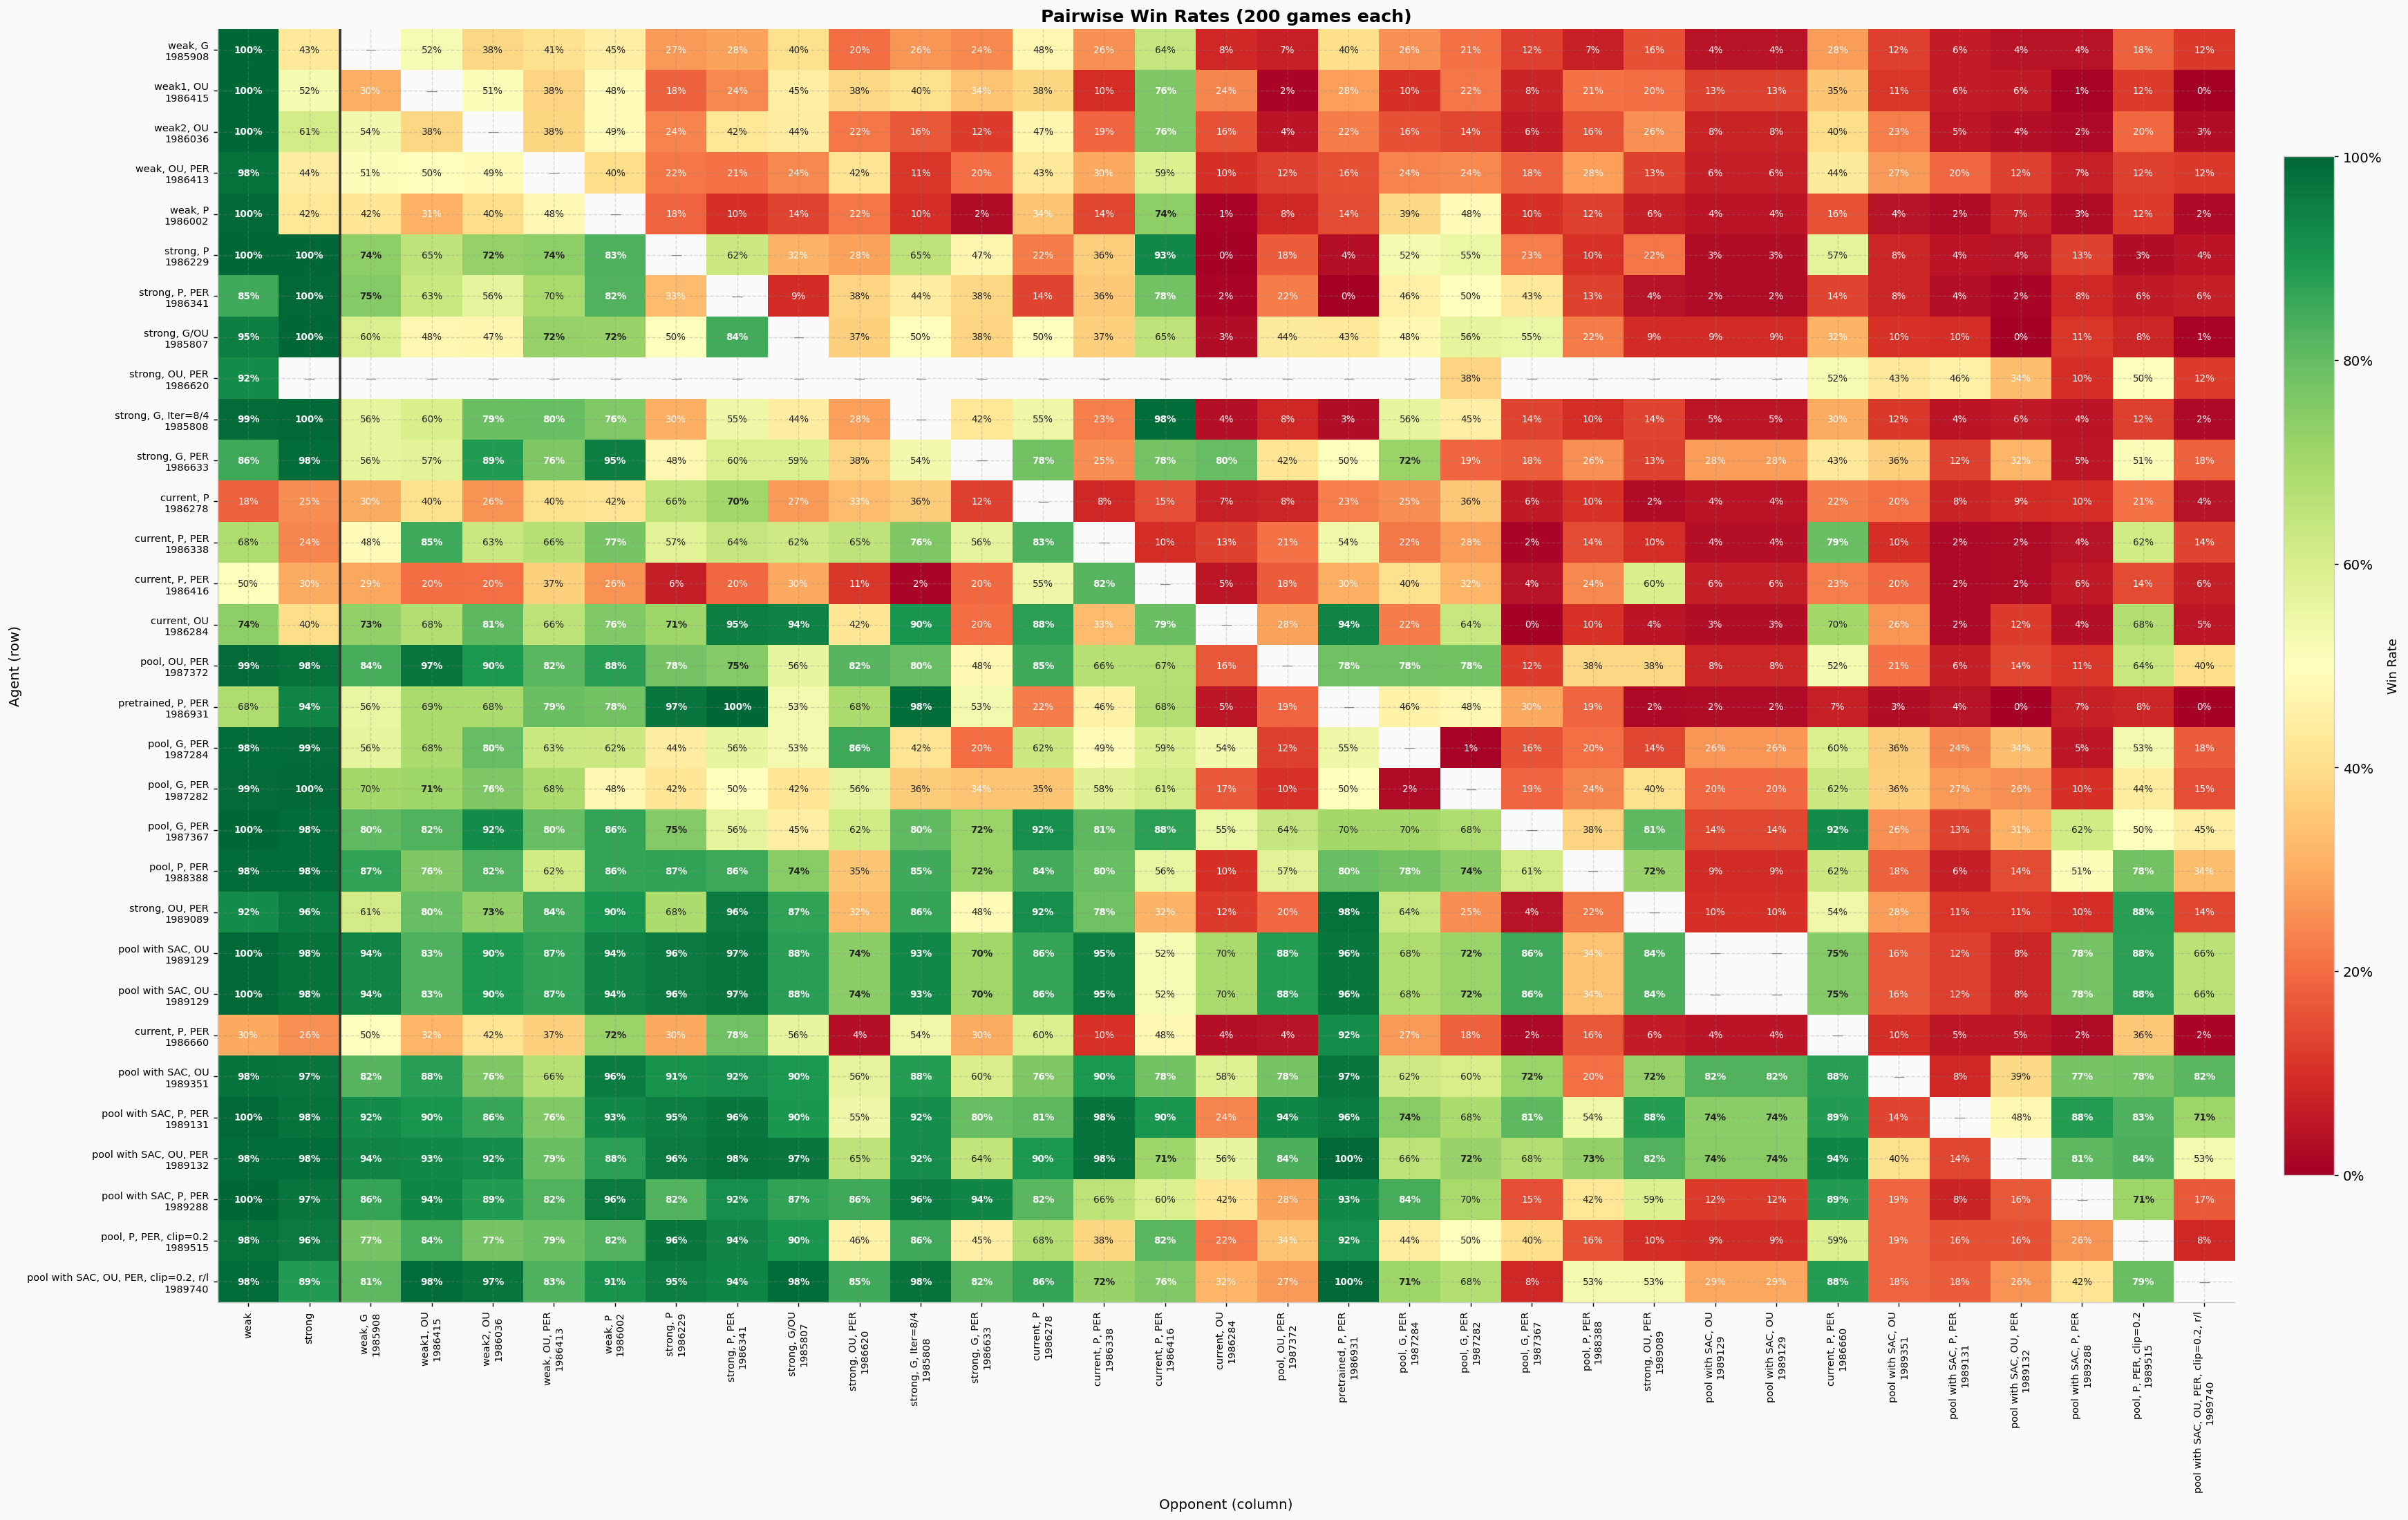

In [645]:
fig, ax = plt.subplots(figsize=(max(12, len(all_opponents) * 0.9),
                                max(6, len(agent_names) * 0.55)))

data = win_rate_matrix.values.astype(float)

im = ax.imshow(data, cmap='RdYlGn', vmin=0, vmax=1, aspect='auto')

# annotations
for i in range(len(agent_names)):
    for j in range(len(all_opponents)):
        val = data[i, j]
        if np.isnan(val):
            ax.text(j, i, '—', ha='center', va='center', fontsize=9, color='#888')
        else:
            r = results2[agent_names[i]].get(all_opponents[j])
            w, l, t = r
            color = 'white' if val < 0.35 or val > 0.75 else '#222'
            ax.text(j, i, f'{val:.0%}', #\n{w}W {l}L {t}T',
                    ha='center', va='center', fontsize=7.5, color=color,
                    fontweight='bold' if val > 0.7 else 'normal')

# axis labels
ax.set_xticks(range(len(all_opponents)))
ax.set_xticklabels(all_opponents, rotation=90, ha='center', fontsize=8)
ax.set_yticks(range(len(agent_names)))
ax.set_yticklabels(agent_names, fontsize=8, )
ax.set_xlabel('Opponent (column)', fontsize=11)
ax.set_ylabel('Agent (row)', fontsize=11)
ax.set_title(f'Pairwise Win Rates ({N_GAMES} games each)')

# colorbar
cbar = fig.colorbar(im, ax=ax, shrink=0.8, pad=0.02)
cbar.ax.set_ylabel('Win Rate', fontsize=10)
cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))

# divider line between basic opponents and agent matchups
ax.axvline(1.5, color='#333', linewidth=2, linestyle='-')

plt.tight_layout()
plt.savefig('pairwise_heatmap.png')
plt.show()

In [447]:
# Compute overall stats per agent
ranking = []
for name in agent_names:
    total_w, total_l, total_t, n_matchups = 0, 0, 0, 0
    for opp in all_opponents:
        r = results2[name].get(opp)
        if r is not None:
            w, l, t = r
            total_w += w
            total_l += l
            total_t += t
            n_matchups += 1
    total_games = total_w + total_l + total_t
    ranking.append({
        'agent': name,
        'matchups': n_matchups,
        'wins': total_w,
        'losses': total_l,
        'ties': total_t,
        'win_rate': total_w / total_games if total_games > 0 else 0,
        'loss_rate': total_l / total_games if total_games > 0 else 0,
    })

ranking_df = pd.DataFrame(ranking).sort_values('win_rate', ascending=True)
ranking_df

agent  matchups  wins  losses  ties  win_rate  \
10          current, P\n1986278        17  1017    1738   645  0.299118   
12     current, P, PER\n1986416        17  1021    2052   327  0.300294   
4              weak, P\n1986002        17  1090    2015   295  0.320588   
3        weak, OU, PER\n1986413        17  1284    1802   314  0.377647   
1            weak1, OU\n1986415        17  1331    1792   277  0.391471   
0              weak, G\n1985908        17  1342    1690   368  0.394706   
2            weak2, OU\n1986036        17  1360    1787   253  0.400000   
7       strong, P, PER\n1986341        17  1646    1600   154  0.484118   
11     current, P, PER\n1986338        17  1837    1014   549  0.540294   
6            strong, P\n1986229        17  1891    1270   239  0.556176   
8         strong, G/OU\n1985807        17  1899    1287   214  0.558529   
15        pool, G, PER\n1987284        17  2131     996   273  0.626765   
9      strong, OU, PER\n1986620        17  2132    1103   165  0.627059   
14  pretrained, P, PER\n1986931        17  2141    1055   204  0.629706   
13         current, OU\n1986284        17  2228     591   581  0.655294   
5       strong, G, PER\n1986633        17  2287     921   192  0.672647   

    loss_rate  
10   0.511176  
12   0.603529  
4    0.592647  
3    0.530000  
1    0.527059  
0    0.497059  
2    0.525588  
7    0.470588  
11   0.298235  
6    0.373529  
8    0.378529  
15   0.292941  
9    0.324412  
14   0.310294  
13   0.173824  
5    0.270882

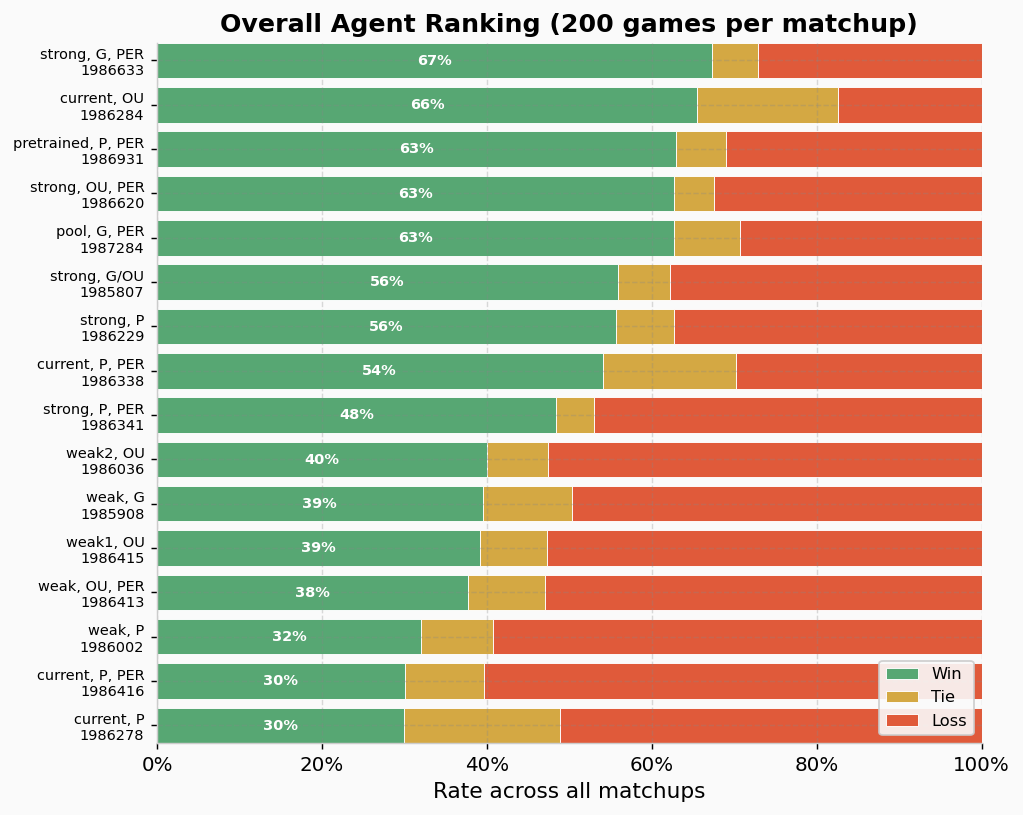

In [448]:
fig, ax = plt.subplots(figsize=(8, max(4, len(agent_names) * 0.4)))

y = range(len(ranking_df))
bar_w = ranking_df['win_rate'].values
bar_l = ranking_df['loss_rate'].values
bar_t = 1.0 - bar_w - bar_l

ax.barh(y, bar_w, color='#57A773', label='Win', edgecolor='white', linewidth=0.5)
ax.barh(y, bar_t, left=bar_w, color='#D4A843', label='Tie', edgecolor='white', linewidth=0.5)
ax.barh(y, bar_l, left=bar_w + bar_t, color='#E05A3A', label='Loss', edgecolor='white', linewidth=0.5)

# labels
for i, (_, row) in enumerate(ranking_df.iterrows()):
    ax.text(row['win_rate'] / 2, i, f"{row['win_rate']:.0%}",
            ha='center', va='center', fontsize=8, fontweight='bold', color='white')

ax.set_yticks(y)
ax.set_yticklabels(ranking_df['agent'].values, fontsize=8)
ax.set_xlim(0, 1)
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
ax.set_xlabel('Rate across all matchups')
ax.set_title(f'Overall Agent Ranking ({N_GAMES} games per matchup)')
ax.legend(loc='lower right', fontsize=9)

plt.tight_layout()
plt.savefig('agent_ranking.png')
plt.show()

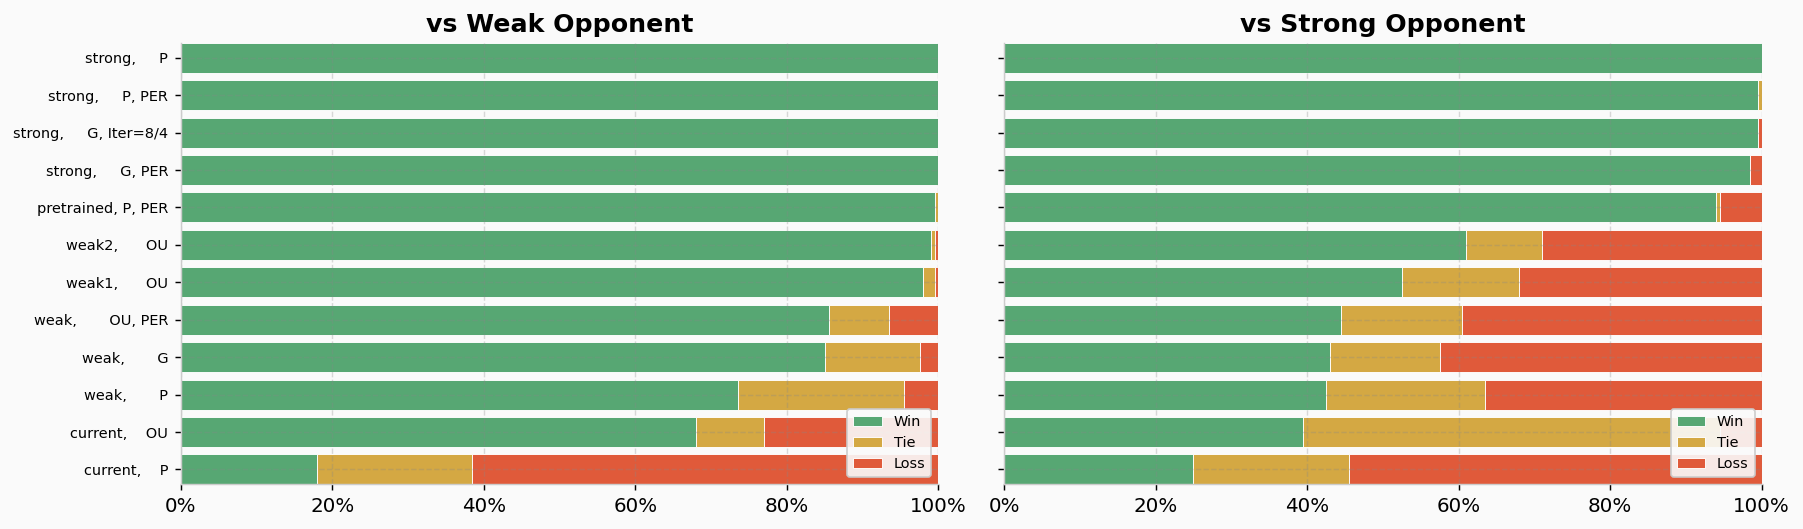

In [293]:
fig, axes = plt.subplots(1, 2, figsize=(14, max(4, len(agent_names) * 0.35)),
                         sharey=True)

for ax, opp_type in zip(axes, ['weak', 'strong']):
    rates = []
    for name in agent_names:
        r = results2[name][opp_type]
        w, l, t = r
        rates.append({'agent': name, 'Win': w/N_GAMES, 'Tie': t/N_GAMES, 'Loss': l/N_GAMES})
    df = pd.DataFrame(rates).sort_values('Win', ascending=True)

    y = range(len(df))
    ax.barh(y, df['Win'],  color='#57A773', label='Win',  edgecolor='white', linewidth=0.5)
    ax.barh(y, df['Tie'],  left=df['Win'], color='#D4A843', label='Tie', edgecolor='white', linewidth=0.5)
    ax.barh(y, df['Loss'], left=df['Win']+df['Tie'], color='#E05A3A', label='Loss', edgecolor='white', linewidth=0.5)

    ax.set_yticks(y)
    ax.set_yticklabels(df['agent'].values, fontsize=8)
    ax.set_xlim(0, 1)
    ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
    ax.set_title(f'vs {opp_type.capitalize()} Opponent')
    ax.legend(loc='lower right', fontsize=8)

plt.tight_layout()
plt.savefig('vs_basic_opponents.png')
plt.show()

# Win rates throughout training

In [341]:
# load the jobs for which win rate logs exist
JOB_IDs = {
           "weak, Ornstein": "1986415",
           "weak, Ornstein, PER": "1986413",
           "strong, Pink, PER": "1986341",
           "strong, Gaussian, PER": "1986633",
           "strong, Ornstein, PER": "1986620",
           "current self, Pink": "1986278",
           "current self, Ornstein": "1986284",
           "pretrained self, Pink, PER": "1986931",
           "pool, Gaussian, PER": "1987284",
           } 
paths_map = {name: f"./{job_id}/logs/win_rate_log.csv" for name, job_id in JOB_IDs.items()}


In [342]:
runs = {}
for name, path in paths_map.items():
    df = pd.read_csv(path)
    df.columns = df.columns.str.strip()
    runs[name] = df
    print(f"{name}: {len(df)} episodes, "
        f"{df['total_steps'].iloc[-1]} total steps, "
        )

weak, Ornstein: 250 episodes, 3244910 total steps, 
weak, Ornstein, PER: 250 episodes, 2910178 total steps, 
strong, Pink, PER: 250 episodes, 2290041 total steps, 
strong, Gaussian, PER: 250 episodes, 2088600 total steps, 
strong, Ornstein, PER: 250 episodes, 2911090 total steps, 
current self, Pink: 250 episodes, 11782223 total steps, 
current self, Ornstein: 250 episodes, 11326407 total steps, 
pretrained self, Pink, PER: 50 episodes, 517603 total steps, 
pool, Gaussian, PER: 250 episodes, 4879072 total steps, 


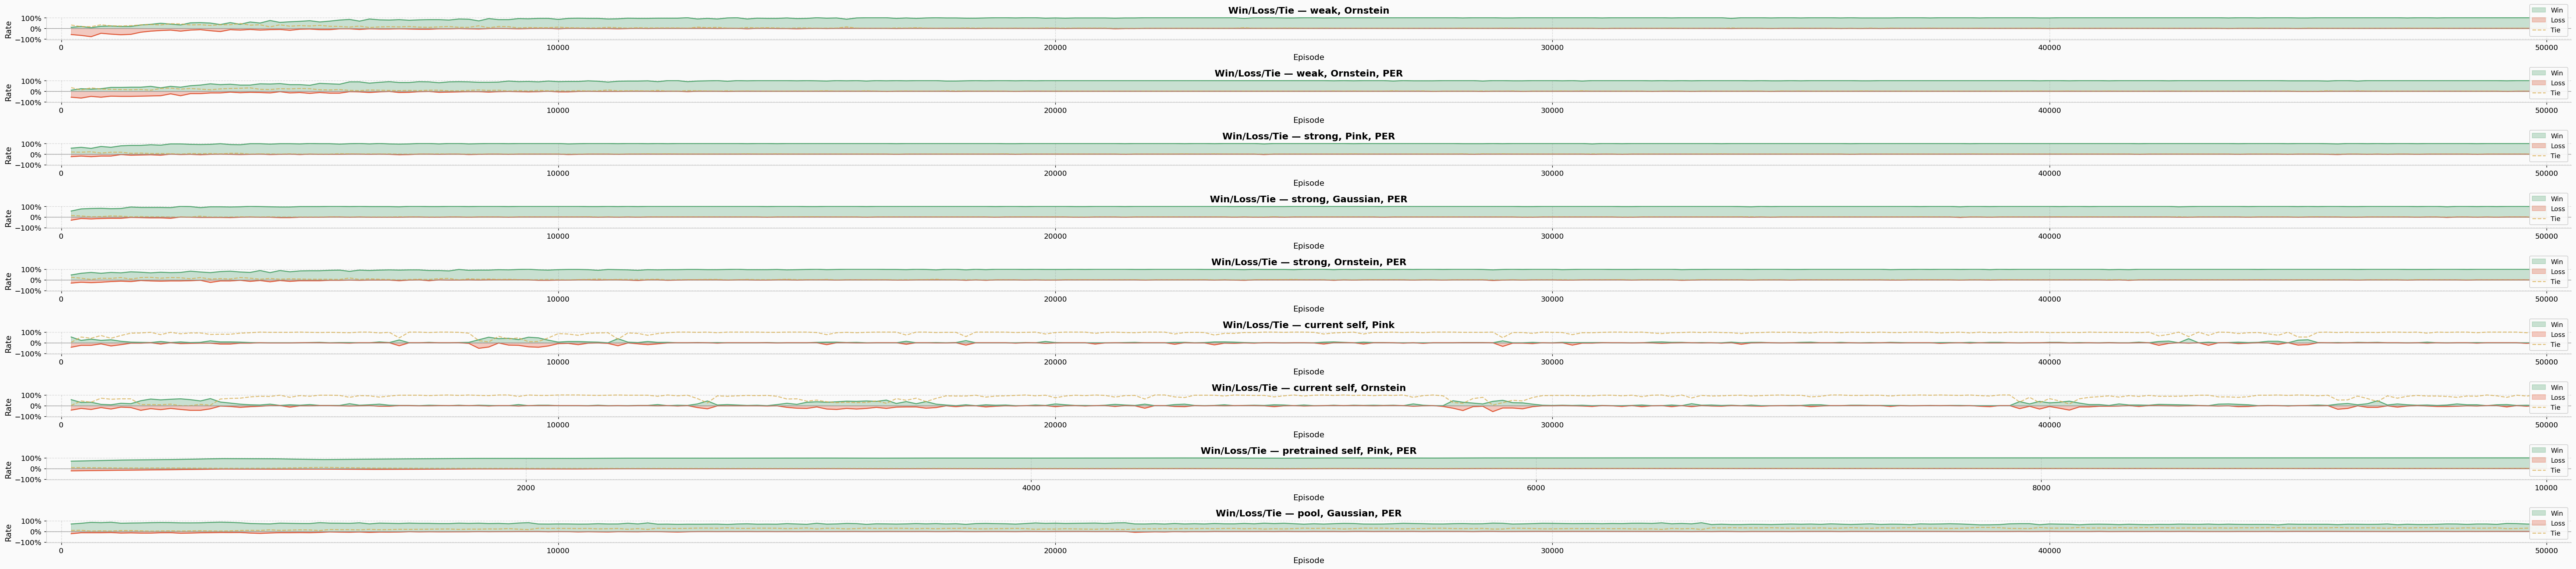

In [343]:
n_runs = len(runs)
fig, axes = plt.subplots(n_runs, 1, figsize=(8 * n_runs, 15), squeeze=False)

for i, (name, df) in enumerate(runs.items()):
    ax = axes[i, 0]
    ax.fill_between(df['episode'], 0, df['win_rate'],
                    alpha=0.3, color='#57A773', label='Win')
    ax.fill_between(df['episode'], 0, -df['loss_rate'],
                    alpha=0.3, color='#E05A3A', label='Loss')
    ax.plot(df['episode'], df['win_rate'],  color='#57A773', linewidth=1.5)
    ax.plot(df['episode'], -df['loss_rate'], color='#E05A3A', linewidth=1.5)
    ax.plot(df['episode'], df['tie_rate'],  color='#D4A843', linewidth=1.5,
            alpha=0.7, label='Tie', linestyle='--')
    ax.axhline(0, color='#999999', linewidth=0.8)
    ax.set_ylim(-1.05, 1.05)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Rate')
    ax.set_title(f'Win/Loss/Tie — {name}')
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
    ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

# General analysis (incl. derived statistics)

In [353]:
# load the data 
JOB_IDs = {"strong, Gaussian/Orn": "1985807", 
           "strong, Iter=8/4, Gauss/Orn": "1985808",
           "strong, Pink": "1986229",
           "strong, Gaussian, PER": "1986633",
           "strong, Pink, PER": "1986341",
           "strong, Ornstein, PER": "1986620",
           "pretrained self, Pink, PER": "1986931",
           "pool, Gaussian, PER": "1987284",
           "current self, Pink": "1986278",
           "current self, Ornstein": "1986284",
           #"weak, Ornstein-Uhlenbeck, ": "1986415",
           #"weak, Ornstein-Uhlenbeck": "1986036", # slightly lower win rate in eval
           #"weak, Gaussian": "1985908", # can also have 99.5% seldomly
           #"weak, Pink": "1986002", # slightly lower win rate (99.5%)
           #"weak, Ornstein, PER": "1986413",
           } 
paths_map = {name: f"./{job_id}/logs/training_log.csv" for name, job_id in JOB_IDs.items()}


In [354]:
paths_map

{'strong, Gaussian/Orn': './1985807/logs/training_log.csv',
 'strong, Iter=8/4, Gauss/Orn': './1985808/logs/training_log.csv',
 'strong, Pink': './1986229/logs/training_log.csv',
 'strong, Gaussian, PER': './1986633/logs/training_log.csv',
 'strong, Pink, PER': './1986341/logs/training_log.csv',
 'strong, Ornstein, PER': './1986620/logs/training_log.csv',
 'pretrained self, Pink, PER': './1986931/logs/training_log.csv',
 'pool, Gaussian, PER': './1987284/logs/training_log.csv',
 'current self, Pink': './1986278/logs/training_log.csv',
 'current self, Ornstein': './1986284/logs/training_log.csv'}

In [355]:
# STYLE SETUP
plt.rcParams.update({
    'figure.facecolor':     '#fafafa',
    'axes.facecolor':       '#fafafa',
    'axes.edgecolor':       '#cccccc',
    'axes.grid':            True,
    'axes.spines.top':      False,
    'axes.spines.right':    False,
    'axes.xmargin':         0.01,
    'axes.ymargin':         0.0,   
    'grid.alpha':           0.3,
    'grid.color':           '#888888',
    'grid.linestyle':       '--',
    'font.family':          'sans-serif',
    'font.size':            11,
    'axes.titlesize':       14,
    'axes.titleweight':     'bold',
    'axes.labelsize':       12,
    'legend.fontsize':      10,
    'legend.framealpha':    0.9,
    'legend.edgecolor':     '#cccccc',
    'figure.dpi':           130,
    'savefig.dpi':          200,
    'savefig.bbox':         'tight',
})

COLORS = ['#2176AE', # blue
          '#57A773', # green
          '#D4A843', # yellow
          '#E87EA1', # pink
          '#E05A3A', # orange
          '#8B5FBF', # purple
          '#27EEF5', # turquoise
          '#F52754', # red
          '#B2DE90', # light green
          ]

SMOOTHING_WINDOW = 100

def get_color(i):
    return COLORS[i % len(COLORS)]

In [356]:
# ** LOAD DATA **
def load_training_data(paths_map) -> dict:
    runs = {}
    for name, path in paths_map.items():
        df = pd.read_csv(path)
        df.columns = df.columns.str.strip()
        # derive smoothed values for calmer plots
        df['smoothed_episode_reward'] = df['episode_reward'].rolling(SMOOTHING_WINDOW,
                                                                    min_periods=1).mean()
        df['win']  = (df['winner'] == 1).astype(int)
        df['loss'] = (df['winner'] == -1).astype(int)
        df['tie']  = (df['winner'] == 0).astype(int)
        df['win_rate']  = df['win'].rolling(SMOOTHING_WINDOW, min_periods=1).mean()
        df['loss_rate'] = df['loss'].rolling(SMOOTHING_WINDOW, min_periods=1).mean()
        df['tie_rate']  = df['tie'].rolling(SMOOTHING_WINDOW, min_periods=1).mean()
        
        runs[name] = df
        print(f"{name}: {len(df)} episodes, "
            f"{df['total_steps'].iloc[-1]} total steps, "
            )
    return runs

runs = load_training_data(paths_map=paths_map)

strong, Gaussian/Orn: 50000 episodes, 2370322 total steps, 
strong, Iter=8/4, Gauss/Orn: 50000 episodes, 2762123 total steps, 
strong, Pink: 50000 episodes, 2844953 total steps, 
strong, Gaussian, PER: 50000 episodes, 2088600 total steps, 
strong, Pink, PER: 50000 episodes, 2290041 total steps, 
strong, Ornstein, PER: 50000 episodes, 2911090 total steps, 
pretrained self, Pink, PER: 10000 episodes, 517603 total steps, 
pool, Gaussian, PER: 50000 episodes, 4879072 total steps, 
current self, Pink: 50000 episodes, 11782223 total steps, 
current self, Ornstein: 50000 episodes, 11326407 total steps, 


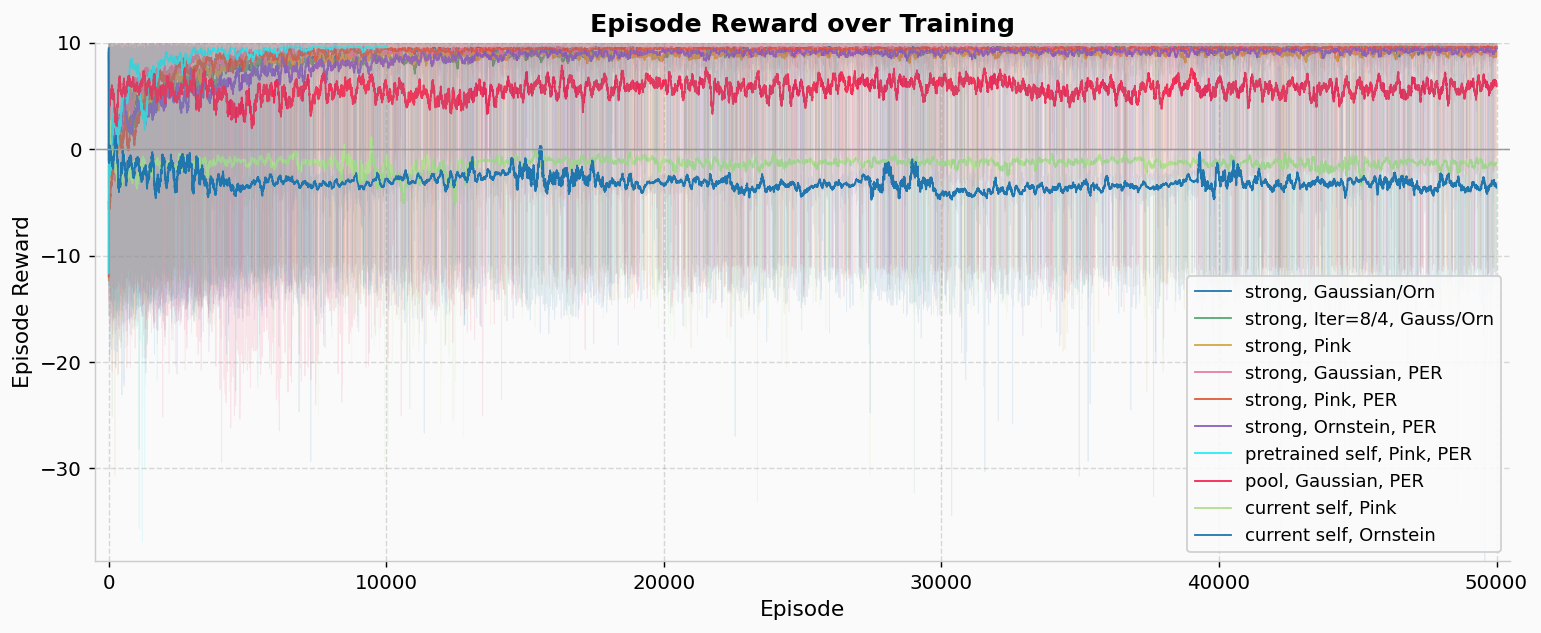

In [357]:
fig, ax = plt.subplots(figsize=(12, 5))
for i, (name, df) in enumerate(runs.items()):
    c = get_color(i)
    ax.plot(df['episode'], df['episode_reward'], 
            alpha=0.1, color=c, linewidth=0.5)
    ax.plot(df['episode'], df['smoothed_episode_reward'], 
            color=c, linewidth=1,
            label=name)
ax.set_xlabel('Episode')
ax.set_ylabel('Episode Reward')
ax.set_title('Episode Reward over Training')
ax.legend()
ax.axhline(0, color='#999999', linewidth=0.8, linestyle='-')
plt.tight_layout()
plt.show()

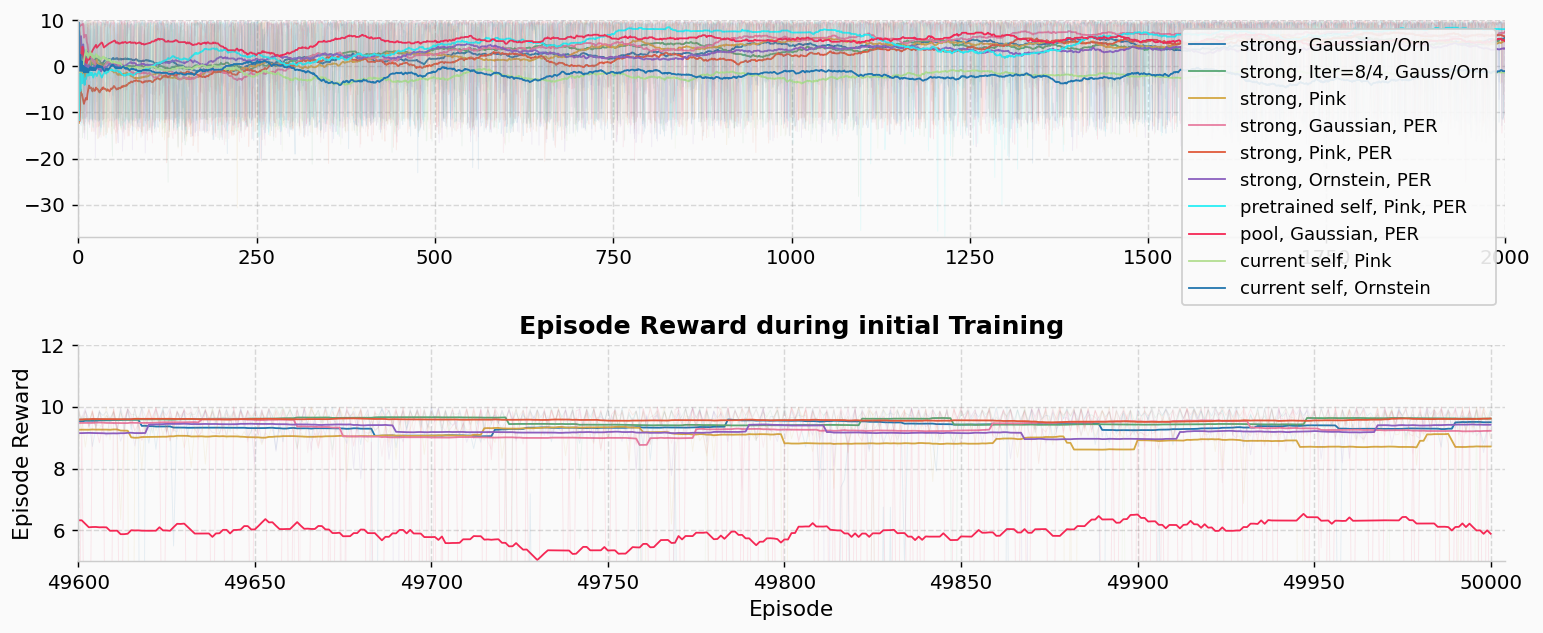

In [358]:
# close up
EPISODE_MAX = 2000
EPISODE_MIN = 49_600

windows = [
    ("Early training", lambda df: df[df["episode"] <= EPISODE_MAX], (0, EPISODE_MAX)),
    ("Late training",  lambda df: df[df["episode"] >= EPISODE_MIN], (EPISODE_MIN, None)),
]

fig, axes = plt.subplots(2, 1, figsize=(12, 5))
for j, (title, filter, xlim) in enumerate(windows):
        for i, (name, df) in enumerate(runs.items()):
                ax = axes[j]
                c = get_color(i)
                d = filter(df)
                ax.plot(d['episode'], d['episode_reward'], 
                        alpha=0.1, color=c, linewidth=0.5)
                ax.plot(d['episode'], d['smoothed_episode_reward'], 
                        color=c, linewidth=1,
                        label=name)
        if xlim[1] is None:
                ax.set_xlim(left=xlim[0])
        else:
                ax.set_xlim(*xlim)
axes[-1].set_ylim(bottom=5, top=12)
axes[-1].set_xlabel("Episode")
axes[0].legend()
ax.set_xlabel('Episode')
ax.set_ylabel('Episode Reward')
ax.set_title('Episode Reward during initial Training')
ax.axhline(0, color='#999999', linewidth=0.8, linestyle='-')
plt.tight_layout()
plt.show()

/var/folders/_s/8q5tfyq977g3pp8gp371jhwm0000gn/T/ipykernel_25204/82762100.py:22: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


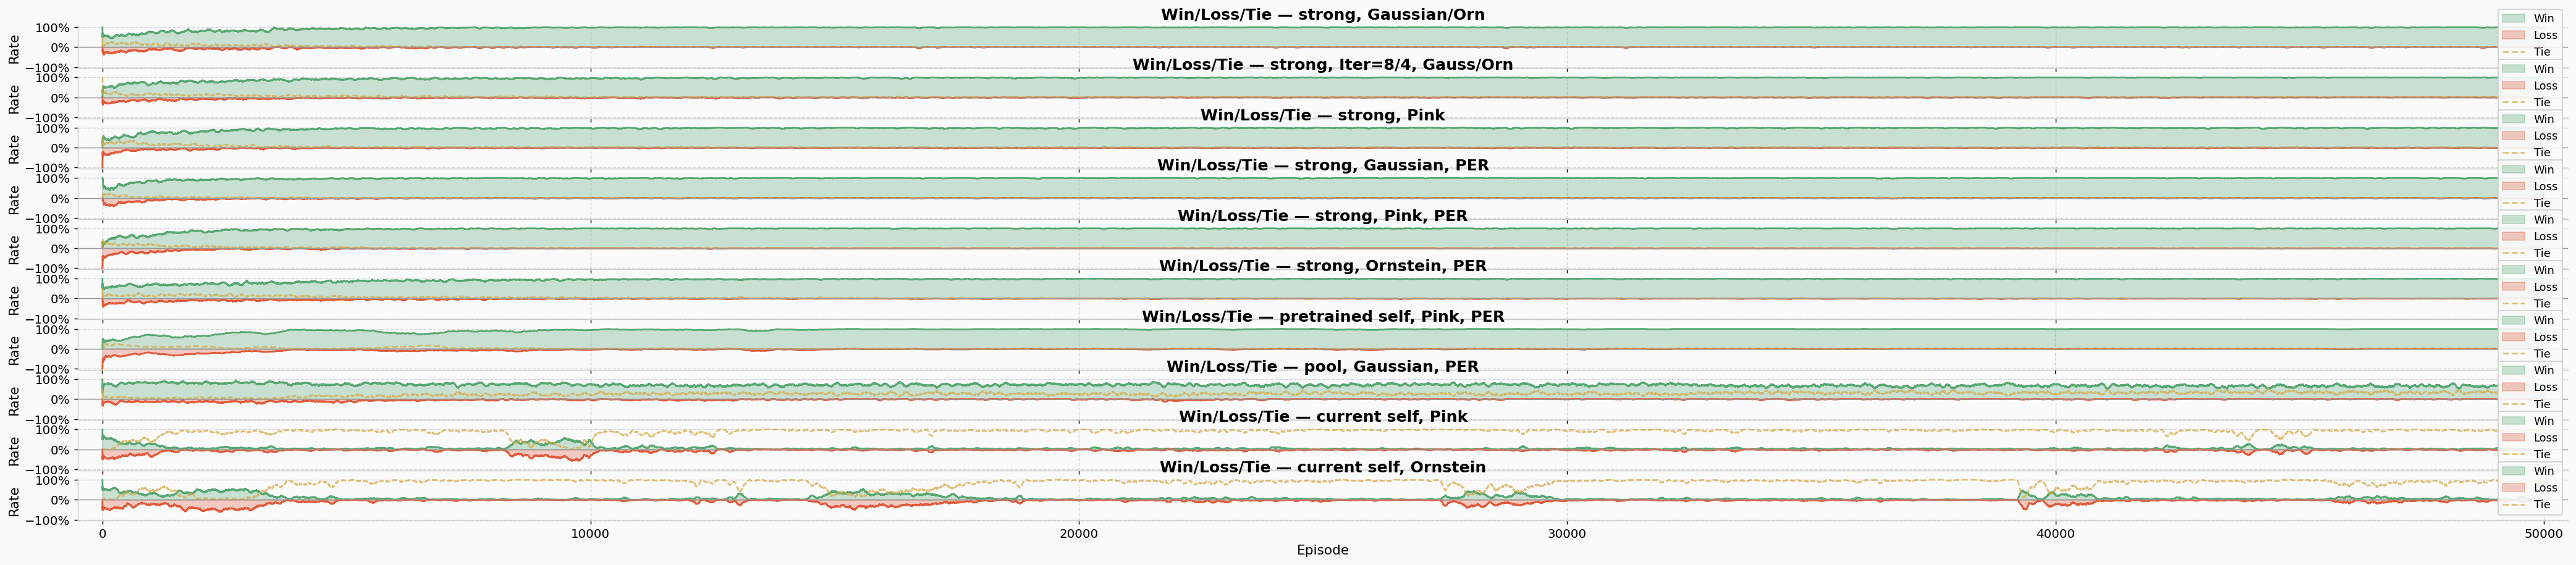

In [359]:
n_runs = len(runs)
fig, axes = plt.subplots(n_runs, 1, figsize=(4 * n_runs, 8), squeeze=False)

for i, (name, df) in enumerate(runs.items()):
    ax = axes[i, 0]
    ax.fill_between(df['episode'], 0, df['win_rate'],
                    alpha=0.3, color='#57A773', label='Win')
    ax.fill_between(df['episode'], 0, -df['loss_rate'],
                    alpha=0.3, color='#E05A3A', label='Loss')
    ax.plot(df['episode'], df['win_rate'],  color='#57A773', linewidth=1.5)
    ax.plot(df['episode'], -df['loss_rate'], color='#E05A3A', linewidth=1.5)
    ax.plot(df['episode'], df['tie_rate'],  color='#D4A843', linewidth=1.5,
            alpha=0.7, label='Tie', linestyle='--')
    ax.axhline(0, color='#999999', linewidth=0.8)
    ax.set_ylim(-1.05, 1.05)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Rate')
    ax.set_title(f'Win/Loss/Tie — {name}')
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
    ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [360]:
# validate win rate every 100 episodes
# see further up


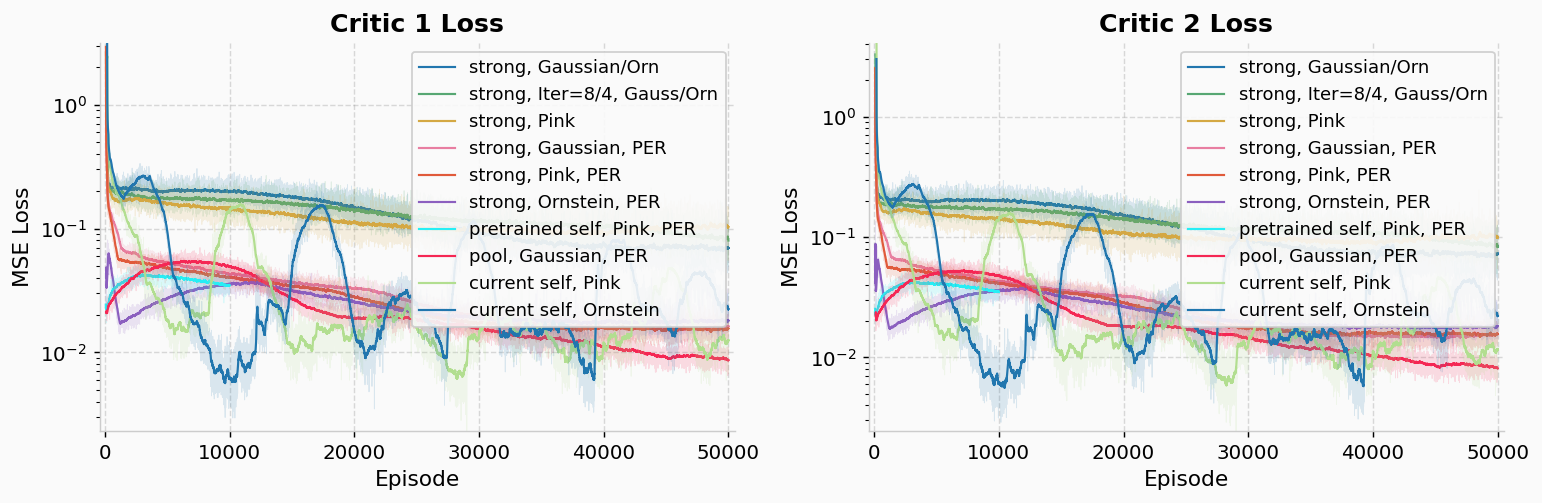

In [361]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, (name, df) in enumerate(runs.items()):
    c = get_color(i)
    # Filter out zeros (episodes before warmup)
    mask = df['critic1_loss'] > 0
    ep = df.loc[mask, 'episode']

    for j, col in enumerate(['critic1_loss', 'critic2_loss']):
        ax = axes[j]
        raw = df.loc[mask, col]
        smooth = raw.rolling(SMOOTHING_WINDOW, min_periods=1).mean()
        ax.plot(ep, raw, alpha=0.15, color=c, linewidth=0.5)
        ax.plot(ep, smooth, color=c, linewidth=1.2, label=name)

for j, title in enumerate(['Critic 1 Loss', 'Critic 2 Loss']):
    axes[j].set_xlabel('Episode')
    axes[j].set_ylabel('MSE Loss')
    axes[j].set_title(title)
    axes[j].legend()
    axes[j].set_yscale('log')

plt.tight_layout()
plt.show()

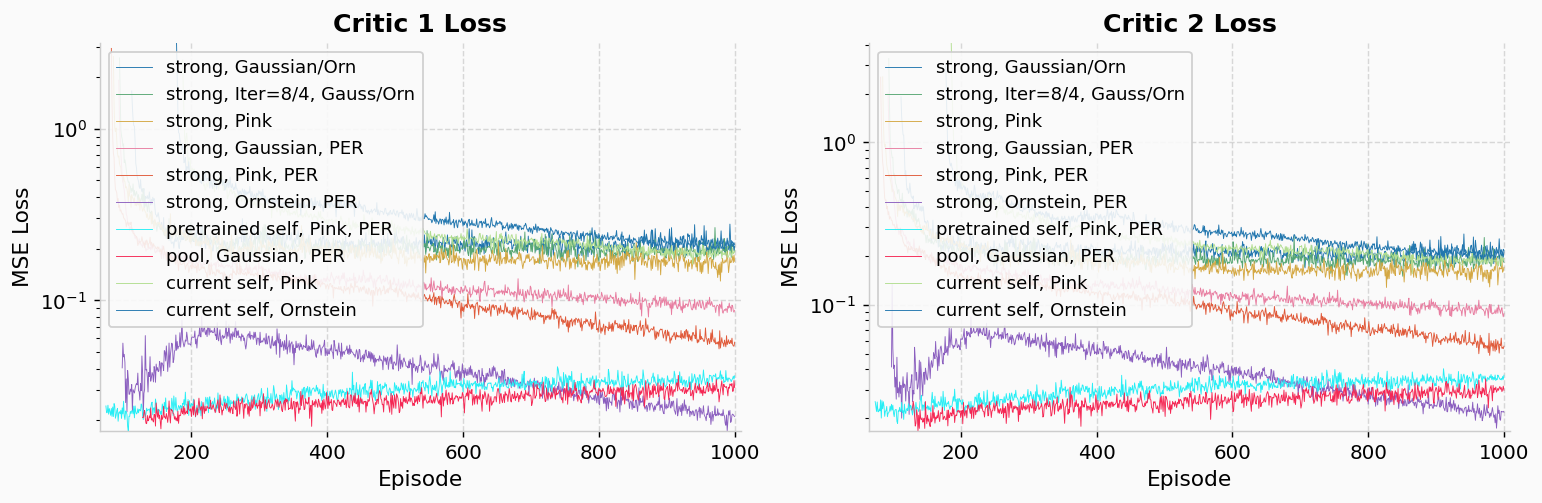

In [362]:
# zoom in to the beginning
EPISODE_MAX = 1000

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, (name, df) in enumerate(runs.items()):
    c = get_color(i)
    d = df[df["episode"] <= EPISODE_MAX]

    # Filter out zeros (episodes before warmup)
    mask = d['critic1_loss'] > 0
    ep = d.loc[mask, 'episode']

    for j, col in enumerate(['critic1_loss', 'critic2_loss']):
        ax = axes[j]
        raw = d.loc[mask, col]
        smooth = raw.rolling(SMOOTHING_WINDOW, min_periods=1).mean()
        ax.plot(ep, raw, alpha=1, color=c, linewidth=0.5, label=name)
        #ax.plot(ep, smooth, color=c, linewidth=2, label=name)

for j, title in enumerate(['Critic 1 Loss', 'Critic 2 Loss']):
    axes[j].set_xlabel('Episode')
    axes[j].set_ylabel('MSE Loss')
    axes[j].set_title(title)
    axes[j].legend()
    axes[j].set_yscale('log')

plt.tight_layout()
plt.show()

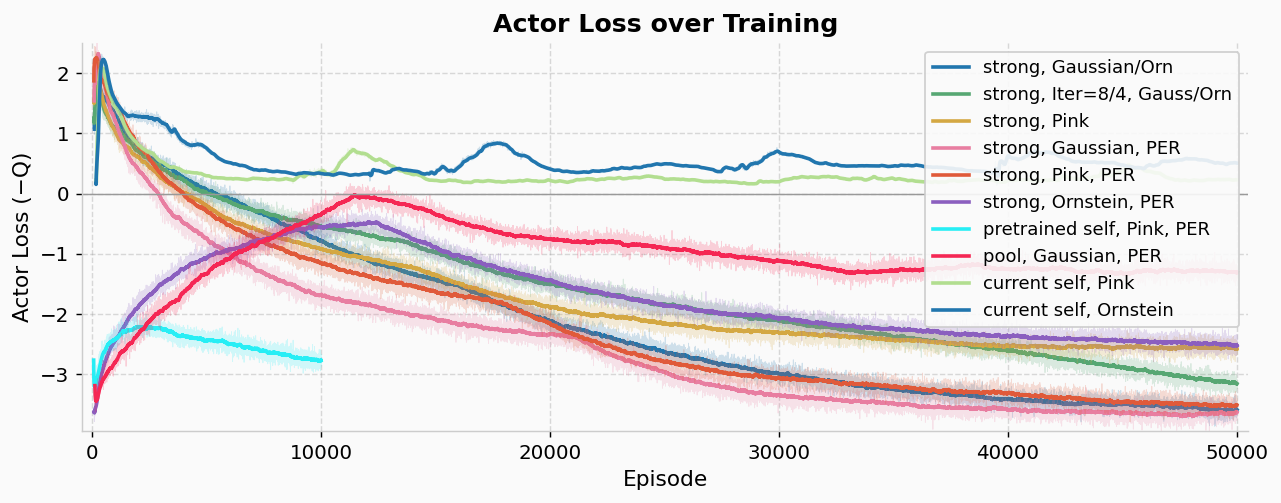

In [363]:
fig, ax = plt.subplots(figsize=(10, 4))
for i, (name, df) in enumerate(runs.items()):
    c = get_color(i)
    mask = df['actor_loss'] != 0
    ep = df.loc[mask, 'episode']
    raw = df.loc[mask, 'actor_loss']
    smooth = raw.rolling(SMOOTHING_WINDOW, min_periods=1).mean()
    ax.plot(ep, raw, alpha=0.2, color=c, linewidth=0.5)
    ax.plot(ep, smooth, color=c, linewidth=2, label=name)
ax.set_xlabel('Episode')
ax.set_ylabel('Actor Loss (−Q)')
ax.set_title('Actor Loss over Training')
ax.legend()
ax.axhline(0, color='#999999', linewidth=0.8, linestyle='-')
plt.tight_layout()
plt.show()

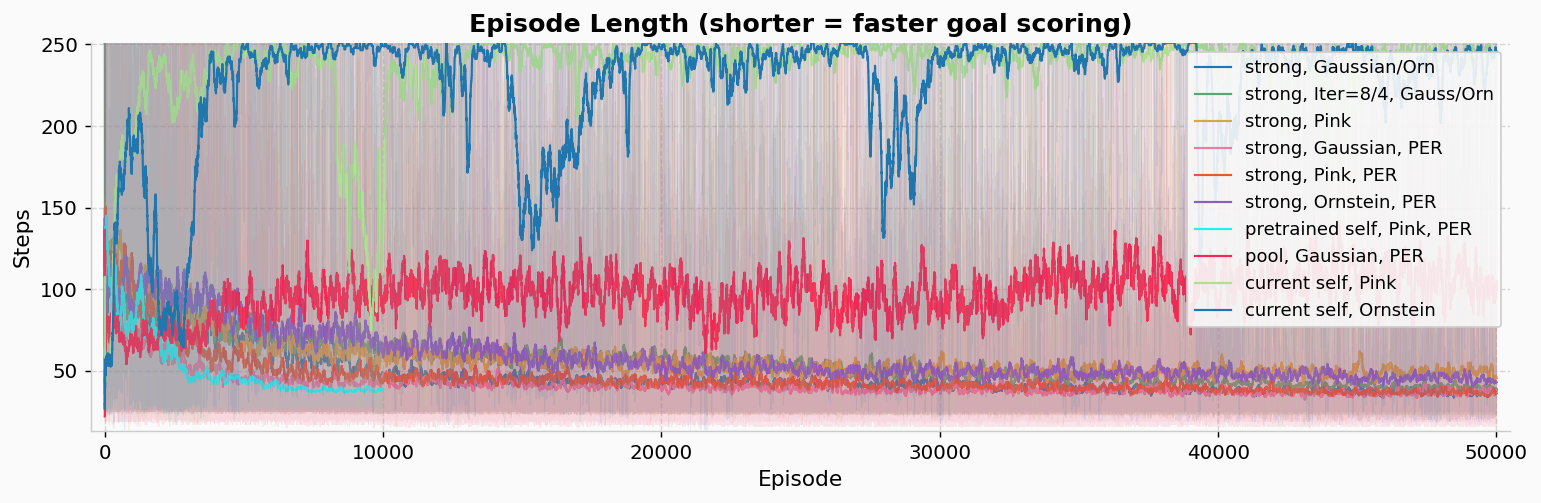

In [364]:
fig, ax = plt.subplots(figsize=(12, 4))
for i, (name, df) in enumerate(runs.items()):
    c = get_color(i)
    smooth = df['episode_length'].rolling(SMOOTHING_WINDOW, min_periods=1).mean()
    ax.plot(df['episode'], df['episode_length'], alpha=0.1, color=c, linewidth=0.5)
    ax.plot(df['episode'], smooth, color=c, linewidth=1.2, label=name)
#ax.axhline(250, color='#999999', linewidth=1, linestyle=':', label='Max (250)')
ax.set_xlabel('Episode')
ax.set_ylabel('Steps')
ax.set_title('Episode Length (shorter = faster goal scoring)')
ax.legend()
plt.tight_layout()
plt.show()

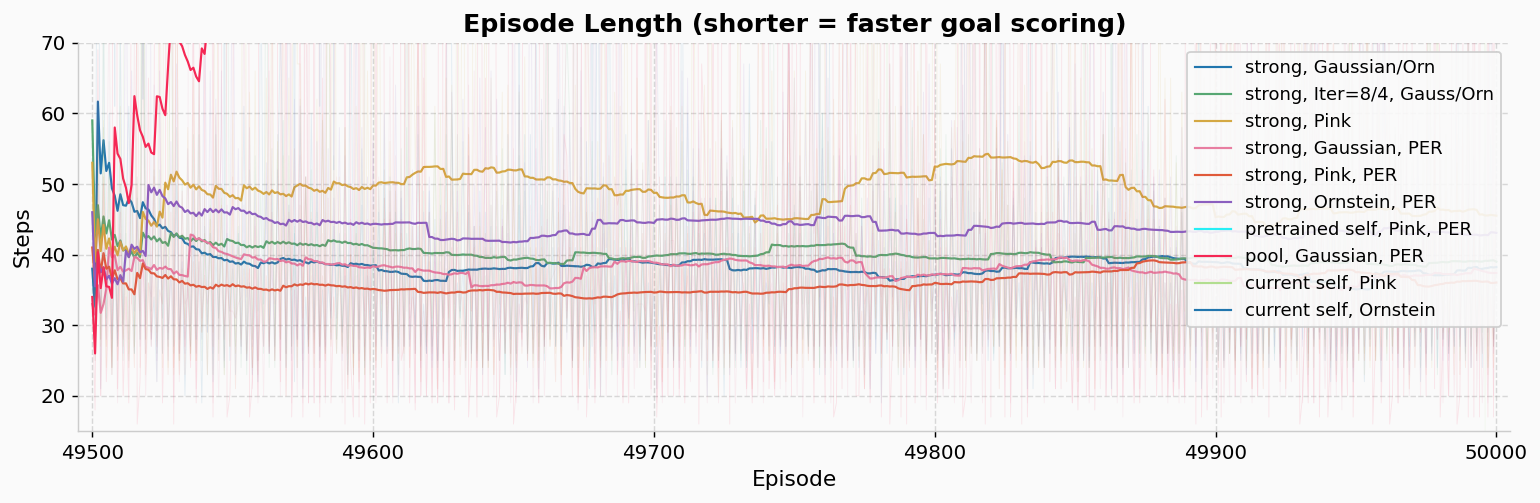

In [365]:
# zoom into the end
EPISODE_MIN = 49_500

fig, ax = plt.subplots(figsize=(12, 4))
for i, (name, df) in enumerate(runs.items()):
    c = get_color(i)
    d = df[df["episode"] >= EPISODE_MIN]
    smooth = d['episode_length'].rolling(SMOOTHING_WINDOW, min_periods=1).mean()
    ax.plot(d['episode'], d['episode_length'], alpha=0.1, color=c, linewidth=0.5)
    ax.plot(d['episode'], smooth, color=c, linewidth=1.2, label=name)
#ax.axhline(250, color='#999999', linewidth=1, linestyle=':', label='Max (250)')
ax.set_xlabel('Episode')
ax.set_ylim(top=70)
ax.set_ylabel('Steps')
ax.set_title('Episode Length (shorter = faster goal scoring)')
ax.legend()
plt.tight_layout()
plt.show()

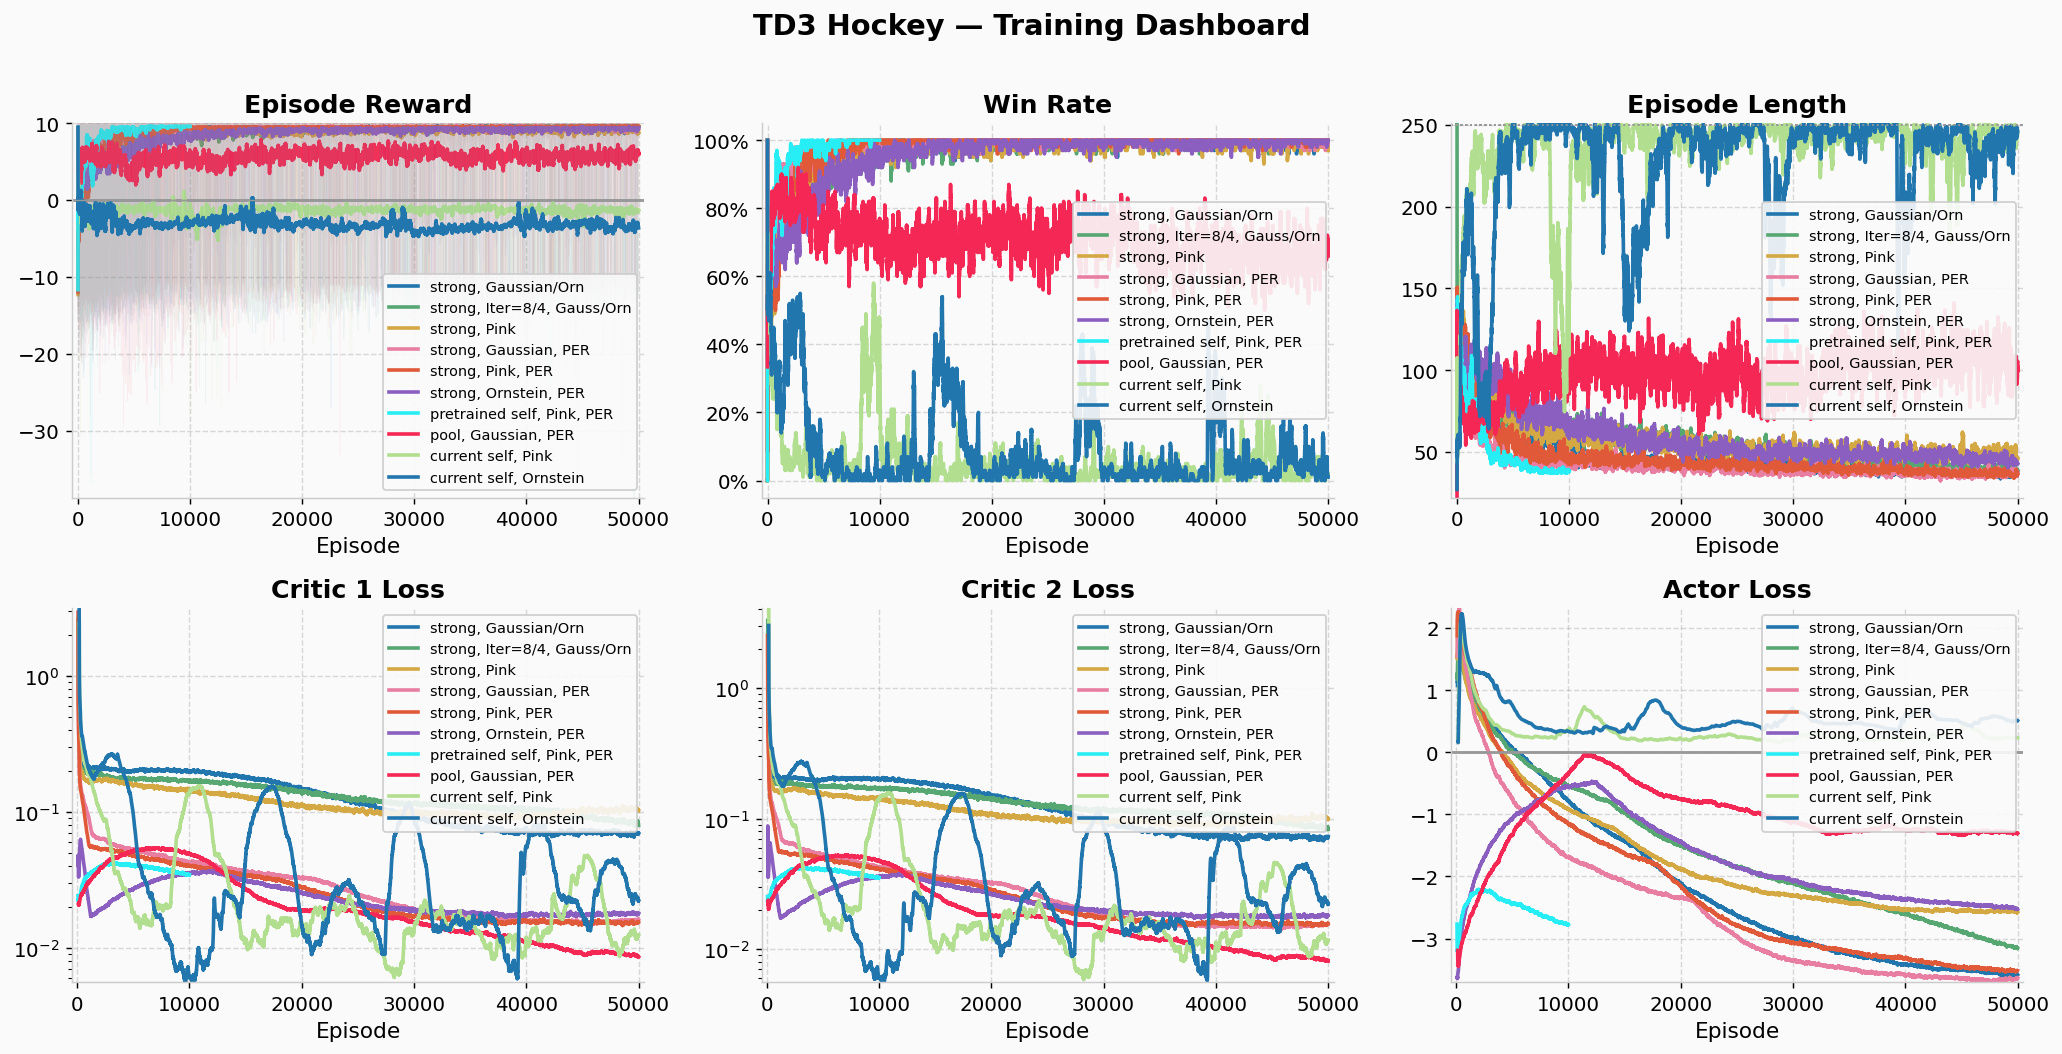

In [366]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
fig.suptitle('TD3 Hockey — Training Dashboard', fontsize=16, fontweight='bold', y=1.01)

for i, (name, df) in enumerate(runs.items()):
    c = get_color(i)
    mask_loss = df['critic1_loss'] > 0
    mask_actor = df['actor_loss'] != 0

    # (0,0) Reward
    ax = axes[0, 0]
    ax.plot(df['episode'], df['episode_reward'], alpha=0.06, color=c, linewidth=0.5)
    ax.plot(df['episode'], df['smoothed_episode_reward'], color=c, linewidth=2, label=name)
    ax.set_title('Episode Reward')
    ax.axhline(0, color='#999999', linewidth=0.8)

    # (0,1) Win rate
    ax = axes[0, 1]
    ax.plot(df['episode'], df['win_rate'], color=c, linewidth=2, label=name)
    ax.set_title('Win Rate')
    ax.set_ylim(-0.05, 1.05)
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))

    # (0,2) Episode length
    ax = axes[0, 2]
    smooth_len = df['episode_length'].rolling(SMOOTHING_WINDOW, min_periods=1).mean()
    ax.plot(df['episode'], smooth_len, color=c, linewidth=2, label=name)
    ax.axhline(250, color='#999999', linewidth=1, linestyle=':')
    ax.set_title('Episode Length')

    # (1,0) Critic 1
    ax = axes[1, 0]
    ep = df.loc[mask_loss, 'episode']
    smooth_c1 = df.loc[mask_loss, 'critic1_loss'].rolling(SMOOTHING_WINDOW, min_periods=1).mean()
    ax.plot(ep, smooth_c1, color=c, linewidth=2, label=name)
    ax.set_title('Critic 1 Loss')
    ax.set_yscale('log')

    # (1,1) Critic 2
    ax = axes[1, 1]
    smooth_c2 = df.loc[mask_loss, 'critic2_loss'].rolling(SMOOTHING_WINDOW, min_periods=1).mean()
    ax.plot(ep, smooth_c2, color=c, linewidth=2, label=name)
    ax.set_title('Critic 2 Loss')
    ax.set_yscale('log')

    # (1,2) Actor loss
    ax = axes[1, 2]
    ep_a = df.loc[mask_actor, 'episode']
    smooth_a = df.loc[mask_actor, 'actor_loss'].rolling(SMOOTHING_WINDOW, min_periods=1).mean()
    ax.plot(ep_a, smooth_a, color=c, linewidth=2, label=name)
    ax.set_title('Actor Loss')
    ax.axhline(0, color='#999999', linewidth=0.8)

for ax in axes.flat:
    ax.set_xlabel('Episode')
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

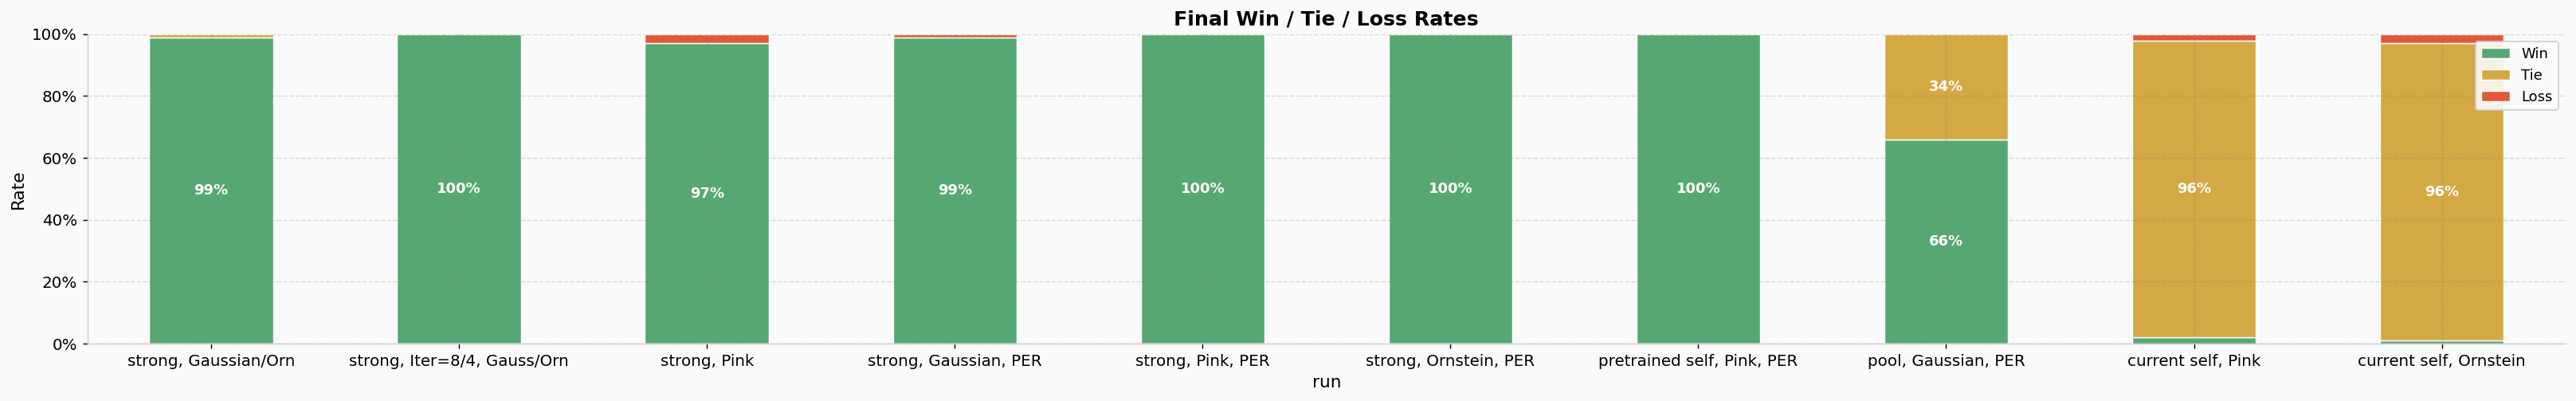

In [367]:
# Compute final rates (last SMOOTHING_WINDOW episodes)
summary = []
for name, df in runs.items():
    tail = df.tail(SMOOTHING_WINDOW)
    summary.append({
        'run': name,
        'Win':  tail['win'].mean(),
        'Tie':  tail['tie'].mean(),
        'Loss': tail['loss'].mean(),
    })
summary_df = pd.DataFrame(summary).set_index('run')

fig, ax = plt.subplots(figsize=(max(4, 2.5 * len(runs)), 4))
bar_colors = ['#57A773', '#D4A843', '#E05A3A']
summary_df.plot.bar(stacked=True, color=bar_colors, edgecolor='white',
                    linewidth=0.8, ax=ax, width=0.5)
ax.set_ylabel('Rate')
ax.set_title('Final Win / Tie / Loss Rates')
ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
ax.legend(loc='upper right')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Annotate percentages
for i, (_, row) in enumerate(summary_df.iterrows()):
    cumulative = 0
    for col, color in zip(['Win', 'Tie', 'Loss'], bar_colors):
        val = row[col]
        if val > 0.03:  # only label if big enough to read
            ax.text(i, cumulative + val / 2, f'{val:.0%}',
                    ha='center', va='center', fontsize=10, fontweight='bold',
                    color='white')
        cumulative += val

plt.tight_layout()
plt.show()

# State visitation

In [368]:
import hockey.hockey_env as hockey_env
from TD3_agent import TD3_Agent
from gymnasium import spaces

env = hockey_env.HockeyEnv()
full_action_space = env.action_space
n_actions_per_player = full_action_space.shape[0] // 2
agent_action_space = spaces.Box(low=full_action_space.low[:n_actions_per_player],
                                high=full_action_space.high[:n_actions_per_player],
                                dtype=full_action_space.dtype)
device = "cpu"
TD3 = TD3_Agent(
    obs_dim = env.observation_space.shape[0],
    act_dim = n_actions_per_player,
    observation_space = env.observation_space,
    action_space = agent_action_space, 
    device = device,
)
TD3.load('./1985808/saved/td3_final.pt')
# collect states from a rollout
states = []
state, _ = env.reset()
for _ in range(10000):
    action = TD3.select_action(state, explore=True)
    state, _, terminated, truncated, _ = env.step(action)
    states.append(state)
    if terminated or truncated:
        state, _ = env.reset()

states = np.array(states)

# PCA projection
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
proj = pca.fit_transform(states)

plt.scatter(proj[:, 0], proj[:, 1], alpha=0.1, s=1)
plt.title(f"State coverage (PCA) — explained variance: {pca.explained_variance_ratio_.sum():.1%}")

Loaded saved from ./1985808/saved/td3_final.pt


TypeError: Expected tuple or list of length 2, got length 0